# DTSA 5511 Deep Learning: Pulmonary Transplant Project

The task: Evaluate the larger dataset, and perform deep learning to identify any predictors of donor pulmonary transplantation. 

## Introduction / Background

Organ transplantation is a life-saving procedure for patients with advanced or end-stage diseases. his process is managed regionally by 56 organ procurement organizations (OPOs), federal contractors which are granted monopoly territories–known as donation service areas (DSAs)–by the Centers for Medicare & Medicaid Services (CMS). OPO performance across the country is highly variable, with some OPOs procuring only a fraction of all transplant-viable organs

## Dataset

Link to the dataset: https://physionet.org/content/orchid/2.0.0/

Link to Github: https://github.com/Vorlon41/Master-of-Data-Science-CU-Boulder-Colorado/blob/main/Machine%20Learning/DTSA%205511%20Introduction%20to%20Deep%20Learning/Final/Pulm%20Transplant%20Project.ipynb

### ORCHID Dataset Overview

- **133,101** deceased donor referrals  
- **8,972** organ donations  
- **13** states covered  

#### Referrals by OPO
- **OPO 1:** 32,148 potential donors  
- **OPO 2:** 16,144 potential donors  
- **OPO 3:** 12,516 potential donors  
- **OPO 4:** 33,641 potential donors  
- **OPO 5:** 15,738 potential donors  
- **OPO 6:** 22,914 potential donors  

All data was de-identified in accordance with **HIPAA** standards using structured data cleansing and date shifting.ORCHID consists of ten tables (CSV files), linked via `PatientID`, and grouped into three categories:

### OPO Referrals  
- **Referral information**: patient demographics & cause of death  
- **Process data**: timestamps for every action (next-of-kin approach, authorization, procurement, death modes)  
- **Outcomes**: binary flags for approached, authorized, procured; plus per-organ recovery results  

### OPO Events  
- **ChemistryEvents**: blood chemistry (kidney panel, LFTs, electrolytes)  
- **CBCEvents**: complete blood count with differential  
- **ABGEvents**: arterial blood gas + ventilator settings  
- **SerologyEvents**: presence/absence of donation-relevant antigens/antibodies  
- **CultureEvents**: infection culture results (blood, urine, other)  
- **HemoEvents**: hemodynamics over `time_event_start` → `time_event_end` (or point measurements)  
- **FluidBalanceEvents**: fluid intake/output over `time_event_start` → `time_event_end`  

### OPO Deaths  
- Captures referring-hospital death data (asystole, brain death timestamps, etc.)  


## Pre Processing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, auc,
    precision_recall_curve, average_precision_score, brier_score_loss, 
)
from sklearn.calibration import calibration_curve
from sklearn.utils import resample, class_weight
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from scipy.stats import pearsonr, mannwhitneyu, chi2_contingency, randint, uniform
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.outliers_influence import variance_inflation_factor
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.metrics import AUC
from xgboost import XGBClassifier
import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.base import clone

from matplotlib import MatplotlibDeprecationWarning

warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)

In [219]:
# Define the file path
file_path = r"C:\Users\chris\OneDrive\Desktop\Deep Learning Project\organ-retrieval-and-collection-of-health-information-for-donation-orchid-2.0.0\cleanedcombineddata.csv"

# Read the CSV into a DataFrame
data = pd.read_csv(file_path)

# Display the first few rows to confirm
print(data.head())

    OPO     PatientID   Age  Gender   HospitalID  brain_death  ABO_Rh  \
0  OPO1  OPO1_P320866  62.0     1.0  OPO1_H23456            0     NaN   
1  OPO1  OPO1_P549364  14.0     0.0  OPO1_H11908            0     NaN   
2  OPO1  OPO1_P536997  55.0     1.0  OPO1_H23111            0     NaN   
3  OPO1  OPO1_P463285  48.0     0.0  OPO1_H26589            0     NaN   
4  OPO1  OPO1_P284978  80.0     0.0   OPO1_H5832            0     NaN   

    HeightIn    WeightKg  approached  ...  ABO_BloodType_A1B  \
0  68.000000   70.000000           0  ...                  0   
1  61.023622   70.500000           0  ...                  0   
2  70.000000   89.500000           1  ...                  0   
3  54.000000   50.340136           0  ...                  0   
4  64.000000  136.500000           0  ...                  0   

   ABO_BloodType_A2  ABO_BloodType_A2B  ABO_BloodType_AB  ABO_BloodType_B  \
0                 0                  0                 0                0   
1                 0   

In [220]:
# Total rows and columns
print("Shape of data:", data.shape)  # (rows, columns)

# Total number of columns
print("Total columns:", len(data.columns))


Shape of data: (133101, 390)
Total columns: 390


#### Lung transplants

In [222]:
# Define lung activity columns
lung_cols = [
    'outcome_lung_left_Recovered for Research',
    'outcome_lung_left_Recovered for Transplant but not Transplanted',
    'outcome_lung_left_Transplanted',
    'outcome_lung_right_Recovered for Research',
    'outcome_lung_right_Recovered for Transplant but not Transplanted',
    'outcome_lung_right_Transplanted'
]

# Identify everyone with any lung evaluation/activity
has_lung_evaluation = data[lung_cols].fillna(0).sum(axis=1) > 0
lung_eval = data[has_lung_evaluation].copy()

# Create a single transplant flag
lung_eval['lung_transplanted'] = (
    lung_eval[['outcome_lung_left_Transplanted', 'outcome_lung_right_Transplanted']]
    .fillna(0)
    .sum(axis=1) > 0
).astype(int)

# Summary counts
evaluated = len(lung_eval)
transplanted = lung_eval['lung_transplanted'].sum()
not_transplanted = evaluated - transplanted

print(f"Patients evaluated for lung transplant: {evaluated}")
print(f"   Actually transplanted: {transplanted}")
print(f"   Evaluated but not transplanted: {not_transplanted}")


Patients evaluated for lung transplant: 3593
   Actually transplanted: 2240
   Evaluated but not transplanted: 1353


#### Remove unwanted columns


In [227]:
# Columns to remove
cols_to_remove = ['PatientID', 'HospitalID']

# Drop them in-place (or assign back if you prefer not to modify original)
lung_eval = lung_eval.drop(columns=cols_to_remove)

# Now print the remaining columns and their dtypes
print(lung_eval.dtypes)


OPO                   object
Age                  float64
Gender               float64
brain_death            int64
ABO_Rh               float64
                      ...   
Race_Black             int64
Race_Hispanic          int64
Race_Other             int64
Race_White             int64
lung_transplanted      int32
Length: 389, dtype: object


#### Missing Data

In [229]:

# Count missing values per column
nan_counts = lung_eval.isna().sum()

# Build a summary DataFrame
missing_df = nan_counts.reset_index()
missing_df.columns = ['column', 'missing_count']
missing_df['percent_missing'] = (missing_df['missing_count'] / len(lung_eval)) * 100

# Show only columns with any missing values, sorted descending
print(
    missing_df[missing_df['missing_count'] > 0]
    .sort_values(by='missing_count', ascending=False)
    .to_string(index=False)
)

                    column  missing_count  percent_missing
              SerumBetaHCG           3591        99.944336
                   TotalMB           3582        99.693849
                       BNP           3554        98.914556
                 TroponinT           3550        98.803228
                  CpkIndex           3531        98.274422
              IndirectBili           3516        97.856944
                 SerumOsmo           3486        97.021987
            IonizedCalcium           3407        94.823267
                       LDH           3392        94.405789
                   Lactate           3389        94.322293
                Fibrinogen           3384        94.183134
                       Cpk           3360        93.515168
                      CKMB           3318        92.346229
                    HgbA1C           3210        89.340384
                 TroponinI           3190        88.783746
                       GGT           3181        88.5332

In [232]:
# Calculate percent missing per column
percent_missing = lung_eval.isna().mean() * 100

# Identify columns to drop (>50% missing)
cols_to_drop = percent_missing[percent_missing > 50].index.tolist()

# Drop them
lung_eval = lung_eval.drop(columns=cols_to_drop)

# Report
print("Dropped columns (>50% missing):")
for col in cols_to_drop:
    print(f"  - {col} ({percent_missing[col]:.1f}% missing)")

print(f"\nRemaining DataFrame shape: {lung_eval.shape}")



Dropped columns (>50% missing):
  - ABO_Rh (60.8% missing)
  - time_asystole (73.4% missing)
  - PH (65.2% missing)
  - PCO2 (65.2% missing)
  - PO2 (65.2% missing)
  - HCO3 (65.2% missing)
  - BE (65.2% missing)
  - FIO2 (65.2% missing)
  - O2SAT (65.2% missing)
  - PIP (66.4% missing)
  - PEEP (65.2% missing)
  - TV (65.3% missing)
  - Rate (65.2% missing)
  - mode_A/C (65.2% missing)
  - mode_APRV (65.2% missing)
  - mode_Apnea Test (65.2% missing)
  - mode_BiPAP (65.2% missing)
  - mode_CMV (65.2% missing)
  - mode_CPAP (65.2% missing)
  - mode_HFOV (65.2% missing)
  - mode_NC (65.2% missing)
  - mode_Other (65.2% missing)
  - mode_PC (65.2% missing)
  - mode_PRVC (65.2% missing)
  - mode_SIMV (65.2% missing)
  - mode_nan (65.2% missing)
  - WBC (61.8% missing)
  - Hct (61.8% missing)
  - Hgb (61.8% missing)
  - Ptl (61.8% missing)
  - Band (82.4% missing)
  - Segs (67.2% missing)
  - Lymp (62.1% missing)
  - Mono (62.1% missing)
  - Eos (63.2% missing)
  - RBC (61.8% missing)
  - 

In [234]:

# Parse MM:SS.s strings into seconds
time_cols = [
    'time_brain_death',
    'time_referred',
    'time_approached',
    'time_authorized',
    'time_procured'
]

def parse_minsec(x):
    if pd.isna(x):
        return np.nan
    try:
        mins, sec = x.split(':')
        return int(mins) * 60 + float(sec)
    except ValueError:
        return np.nan

for col in time_cols:
    lung_eval[f'{col}_seconds'] = lung_eval[col].map(parse_minsec)

# List of new seconds columns
time_sec_cols = [f'{c}_seconds' for c in time_cols]

# Split into training and test before imputing
train_df, test_df = train_test_split(
    lung_eval,
    test_size=0.2,
    stratify=lung_eval['lung_transplanted'],
    random_state=42
)

# Fit KNN imputer on training seconds data
imputer = KNNImputer(n_neighbors=5)
train_df[time_sec_cols] = imputer.fit_transform(train_df[time_sec_cols])

# Apply the same imputer to test data
test_df[time_sec_cols] = imputer.transform(test_df[time_sec_cols])

# Check results
print("Training, post-impute:")
print(train_df[time_sec_cols].describe().round(1))
print("\nTest, post-impute:")
print(test_df[time_sec_cols].describe().round(1))

Training, post-impute:
       time_brain_death_seconds  time_referred_seconds  \
count                    2874.0                 2874.0   
mean                     1683.9                 1822.1   
std                       926.0                  924.9   
min                         0.0                    0.0   
25%                      1020.0                 1153.8   
50%                      1688.9                 1822.1   
75%                      2340.0                 2520.0   
max                      3540.0                 3599.1   

       time_approached_seconds  time_authorized_seconds  time_procured_seconds  
count                   2874.0                   2874.0                 2874.0  
mean                    1309.7                   1556.6                 1772.5  
std                      984.1                    990.0                  960.4  
min                        0.0                      0.0                    0.0  
25%                      300.0                   

In [236]:
# List of (start_seconds, end_seconds, new_hours_column) tuples
intervals = [
    ('time_referred_seconds',    'time_approached_seconds',  'hours_referred_to_approached'),
    ('time_approached_seconds',  'time_authorized_seconds',  'hours_approached_to_authorized'),
    ('time_authorized_seconds',  'time_procured_seconds',    'hours_authorized_to_procured'),
    ('time_asystole_seconds',    'time_referred_seconds',    'hours_asystole_to_referred'),
    ('time_brain_death_seconds', 'time_referred_seconds',    'hours_brain_death_to_referred'),
]

for start, end, new_col in intervals:
    if start in lung_eval.columns and end in lung_eval.columns:
        lung_eval[new_col] = (lung_eval[end] - lung_eval[start]) / 3600

# Quick check: show seconds + hours for the first few rows that have data
print(
    lung_eval.loc[
        lung_eval['time_referred_seconds'].notna(),
        ['time_referred_seconds', 'time_approached_seconds', 'hours_referred_to_approached',
         'time_approached_seconds', 'time_authorized_seconds', 'hours_approached_to_authorized',
         'time_authorized_seconds', 'time_procured_seconds', 'hours_authorized_to_procured']
    ].head()
)


    time_referred_seconds  time_approached_seconds  \
25                 1178.8                   1680.0   
42                  498.1                      NaN   
49                 2460.0                      0.0   
65                 3286.2                    300.0   
92                 3246.4                   1800.0   

    hours_referred_to_approached  time_approached_seconds  \
25                      0.139222                   1680.0   
42                           NaN                      NaN   
49                     -0.683333                      0.0   
65                     -0.829500                    300.0   
92                     -0.401778                   1800.0   

    time_authorized_seconds  hours_approached_to_authorized  \
25                   1680.0                            0.00   
42                   1500.0                             NaN   
49                      0.0                            0.00   
65                   2280.0                            0

In [238]:

# Find all your hours_* columns
hour_cols = [c for c in lung_eval.columns if c.startswith('hours_')]

# Zero-out (or NaN-out) any negatives
for col in hour_cols:
    lung_eval.loc[lung_eval[col] < 0, col] = np.nan

In [240]:
print(lung_eval[hour_cols].describe().T[['count','mean','std','min','max']])


                                 count      mean       std  min       max
hours_referred_to_approached    1099.0  0.302654  0.211922  0.0  0.964639
hours_approached_to_authorized  2562.0  0.136632  0.245235  0.0  0.983333
hours_authorized_to_procured    1758.0  0.344700  0.253019  0.0  0.983333
hours_brain_death_to_referred   1441.0  0.340649  0.239601  0.0  0.985389


In [242]:

# Identify time‐related columns
time_cols = [c for c in lung_eval.columns 
             if c.endswith('_seconds') or c.startswith('hours_')]

# Compute missing counts + percentages
missing_df = lung_eval[time_cols].isna().sum().reset_index()
missing_df.columns = ['column', 'missing_count']
missing_df['percent_missing'] = missing_df['missing_count'] / len(lung_eval) * 100

# Show only those with any missing, sorted descending
print(
    missing_df[missing_df['missing_count'] > 0]
    .sort_values('missing_count', ascending=False)
    .to_string(index=False)
)

                        column  missing_count  percent_missing
  hours_referred_to_approached           2494        69.412747
 hours_brain_death_to_referred           2152        59.894239
  hours_authorized_to_procured           1835        51.071528
hours_approached_to_authorized           1031        28.694684
      time_brain_death_seconds            853        23.740607
       time_approached_seconds            574        15.975508
         time_procured_seconds            548        15.251879
       time_authorized_seconds            547        15.224047
         time_referred_seconds            532        14.806568


#### Imputation of the time variables

In [245]:

# split into training and test before any imputation
train_df, test_df = train_test_split(
    lung_eval,
    test_size=0.2,
    stratify=lung_eval['lung_transplanted'],
    random_state=42
)

# define time‐related columns
time_cols = [c for c in lung_eval.columns 
             if c.endswith('_seconds') or c.startswith('hours_')]

# snapshot pre‐imputation stats on training set
pre_stats = pd.DataFrame({
    'missing_before': train_df[time_cols].isna().sum(),
    'mean_before':    train_df[time_cols].mean(),
    'median_before':  train_df[time_cols].median(),
    'std_before':     train_df[time_cols].std()
})

# drop columns with >50% missing in training set
pct_missing = train_df[time_cols].isna().mean() * 100
to_drop = pct_missing[pct_missing > 50].index.tolist()
train_df = train_df.drop(columns=to_drop)
test_df  = test_df.drop(columns=to_drop)

# update list of columns to impute
cols_to_impute = [c for c in time_cols if c in train_df.columns]

# fit median imputer on training, then apply to both sets
imp = SimpleImputer(strategy='median')
train_df[cols_to_impute] = imp.fit_transform(train_df[cols_to_impute])
test_df[cols_to_impute]  = imp.transform(test_df[cols_to_impute])

# snapshot post‐imputation stats on training set
post_stats = pd.DataFrame({
    'missing_after': train_df[cols_to_impute].isna().sum(),
    'mean_after':    train_df[cols_to_impute].mean(),
    'median_after':  train_df[cols_to_impute].median(),
    'std_after':     train_df[cols_to_impute].std()
})

# combine and compute changes
compare = pre_stats.join(post_stats)
compare['Δmean']    = compare['mean_after']   - compare['mean_before']
compare['Δmedian']  = compare['median_after'] - compare['median_before']
compare['Δstd']     = compare['std_after']    - compare['std_before']
compare['Δmissing'] = compare['missing_after']- compare['missing_before']

# show only columns that changed
print(compare.loc[(compare[['Δmean','Δmedian','Δstd','Δmissing']] != 0).any(axis=1)])



                                missing_before  mean_before  median_before  \
time_brain_death_seconds                   685  1688.908177    1800.000000   
time_referred_seconds                      431  1822.075440    1832.500000   
time_approached_seconds                    464  1310.539419    1380.000000   
time_authorized_seconds                    443  1557.260387    1740.000000   
time_procured_seconds                      445  1772.976534    1800.000000   
hours_referred_to_approached              1995     0.297775       0.254278   
hours_approached_to_authorized             823     0.139753       0.000000   
hours_authorized_to_procured              1483     0.344572       0.300000   
hours_brain_death_to_referred             1717     0.341444       0.304583   

                                 std_before  missing_after   mean_after  \
time_brain_death_seconds        1049.302260            0.0  1715.386221   
time_referred_seconds           1003.226657            0.0  1823.6387

After fitting the median imputer only on your training split and then applying it to both train and test, all five seconds-based time variables lost 100% of their missing values in the training set (missing_after = 0), and the two hours-difference features with <50% missing (hours_approached_to_authorized) also dropped to zero missing.

Looking at the magnitudes of change in the training data:

time_brain_death_seconds mean rose by ~ 26 s (0.44 min), std fell by ~ 132 s

time_referred_seconds mean rose by ~ 1.6 s, std fell by ~ 78 s

time_approached_seconds mean rose by ~ 11 s, std fell by ~ 90 s

time_authorized_seconds mean rose by ~ 28 s, std fell by ~ 84 s

time_procured_seconds mean rose by ~ 4 s, std fell by ~ 84 s

hours_approached_to_authorized mean dropped by ~ 0.04 h (2.4 min), std fell by ~ 0.03 h

All medians stayed exactly the same. These shifts are extremely small relative to the full range of each variable (up to ~ 3 600 s or ~ 1 h) and reflect replacing missing entries with the midpoint of the observed distribution in the training set.

Because the test‐set distributions after transformation aligned closely with the training set (as you saw earlier), this approach introduces negligible distortion while eliminating missingness. It’s therefore safe—and statistically sound—to retain these imputed features for modeling.

#### Ensure One Hot Encoding

In [249]:
# Detect two-valued columns (still may contain NaN)
binary_cols = [
    col for col in lung_eval.columns 
    if lung_eval[col].dropna().nunique() == 2
]

# Map 1→True, 0→False, keeping NaN as <NA>, then cast to BooleanDtype
for col in binary_cols:
    lung_eval[col] = (
        lung_eval[col]
        .map({1: True, 0: False})
        .astype("boolean")    # pandas’ nullable Boolean type
    )

# Verify
print(lung_eval[binary_cols].dtypes)
print(lung_eval[binary_cols].head())



Gender               boolean
brain_death          boolean
approached           boolean
authorized           boolean
procured             boolean
                      ...   
Race_Black           boolean
Race_Hispanic        boolean
Race_Other           boolean
Race_White           boolean
lung_transplanted    boolean
Length: 180, dtype: object
    Gender  brain_death  approached  authorized  procured  transplanted  \
25    True         True        True        True      True          True   
42    True         True       False        True      True          True   
49    True         True        True        True      True          True   
65    True         True        True        True      True          True   
92   False         True        True        True      True          True   

    Tissue_Referral  Eye_Referral  Blood    CSF  ...  ABO_BloodType_A2  \
25             True          True  False  False  ...             False   
42             True          True  False  False  ...   

#### Handle NaN

In [252]:
# Re-identify boolean cols
binary_cols = [
    col for col in lung_eval.columns
    if lung_eval[col].dtype.name == 'boolean'
]

# Fill any <NA> with False
lung_eval[binary_cols] = lung_eval[binary_cols].fillna(False)

# Confirm no more missing in those flags
print(lung_eval[binary_cols].isna().sum().sum(), "total missing flags")


0 total missing flags


#### KNN Imputation of Missing Data

In [255]:

# Split before imputing
train_df, test_df = train_test_split(
    lung_eval,
    test_size=0.2,
    stratify=lung_eval['lung_transplanted'],
    random_state=42
)

# Identify numeric columns with missing values in the training set
numeric_cols = [
    col for col in train_df.select_dtypes(include=[np.number]).columns
    if train_df[col].isna().any()
]

# Snapshot pre-imputation stats on training set
pre_stats = pd.DataFrame({
    'missing_before': train_df[numeric_cols].isna().sum(),
    'mean_before':    train_df[numeric_cols].mean(),
    'median_before':  train_df[numeric_cols].median(),
    'std_before':     train_df[numeric_cols].std(),
})

# Fit KNN imputer on training set and transform both sets
imputer = KNNImputer(n_neighbors=5)
train_df[numeric_cols] = imputer.fit_transform(train_df[numeric_cols])
test_df[numeric_cols]  = imputer.transform(test_df[numeric_cols])

# Snapshot post-imputation stats on training set
post_stats = pd.DataFrame({
    'missing_after': train_df[numeric_cols].isna().sum(),
    'mean_after':    train_df[numeric_cols].mean(),
    'median_after':  train_df[numeric_cols].median(),
    'std_after':     train_df[numeric_cols].std(),
})

# Build comparison table and compute deltas
compare = pre_stats.join(post_stats)
compare['Δmean']    = compare['mean_after']   - compare['mean_before']
compare['Δmedian']  = compare['median_after'] - compare['median_before']
compare['Δstd']     = compare['std_after']    - compare['std_before']
compare['Δmissing'] = compare['missing_after']- compare['missing_before']

# Show only columns where something changed
print(compare.loc[(compare[['Δmean','Δmedian','Δstd','Δmissing']] != 0).any(axis=1)])

                                missing_before  mean_before  median_before  \
HeightIn                                     7    66.688078      67.322835   
Procured_Year                                3  2018.188784    2018.000000   
Intake_BloodProduct                       1039   398.106267       0.000000   
Intake_Colloid                            1039   351.595095       0.000000   
Intake_Crystalloid                        1039  8075.027793    5637.000000   
...                                        ...          ...            ...   
time_procured_seconds                      445  1772.976534    1800.000000   
hours_referred_to_approached              1995     0.297775       0.254278   
hours_approached_to_authorized             823     0.139753       0.000000   
hours_authorized_to_procured              1483     0.344572       0.300000   
hours_brain_death_to_referred             1717     0.341444       0.304583   

                                  std_before  missing_after   m

Across all numeric features with missing values—ranging from basic demographics (e.g. HeightIn) through intake/output volumes to the derived time‐difference metrics—the KNN imputer fitted on the training split eliminated every missing entry (Δmissing equals the negative of the original missing count). Key observations:

Demographics & years (HeightIn, Procured_Year) changed negligibly (Δmean < 0.01, Δstd ≈ –0.007 for height and –0.001 for year), reflecting very few imputed values relative to the full sample.

Fluid volumes (Intake_BloodProduct, Intake_Colloid, Intake_Crystalloid, etc.) saw substantial drops in both mean and standard deviation (e.g. Intake_Crystalloid mean down by 2,905 mL, std down by 1,127 mL), since the majority of missing entries were replaced by the median (zero) and thus moved the distribution center toward zero. Their medians remain at 0 mL.

Procured_Year remains practically identical.

Time‐in‐seconds features (time_procured_seconds, etc.) each shifted mean by only a few seconds (–2.8 s to –48 s) and std by tens of seconds, again because the missing times were filled with the median.

Hours‐difference metrics all saw mean reductions of ~0.10–0.13 h (6–8 minutes) and std reductions of ~0.03–0.05 h, mirroring the seconds‐level shifts upstream.

Because all imputations used only the training data’s distributions before being applied to both train and test, these Δvalues reflect true “sensitivity” in the training set. The relatively small shifts—in both absolute and relative terms—especially for demographics and time metrics, confirm that using KNN imputation here introduces minimal distortion while fully resolving missingness.

#### Drop Original Time Variables

In [258]:
# Drop the original time strings
to_drop = [
    'time_brain_death',
    'time_approached',
    'time_procured',
    'time_authorized'
]
lung_eval = lung_eval.drop(columns=to_drop)

print("Dropped columns:", to_drop)

# Recompute missing counts + percentages
missing_df = lung_eval.isna().sum().reset_index()
missing_df.columns = ['column', 'missing_count']
missing_df['percent_missing'] = missing_df['missing_count'] / len(lung_eval) * 100

#  Show remaining gaps
print(
    missing_df[missing_df['missing_count'] > 0]
    .sort_values('missing_count', ascending=False)
    .to_string(index=False)
)


Dropped columns: ['time_brain_death', 'time_approached', 'time_procured', 'time_authorized']
                        column  missing_count  percent_missing
  hours_referred_to_approached           2494        69.412747
 hours_brain_death_to_referred           2152        59.894239
  hours_authorized_to_procured           1835        51.071528
           Intake_BloodProduct           1302        36.237128
                Intake_Colloid           1302        36.237128
            Intake_Crystalloid           1302        36.237128
                  Intake_Total           1302        36.237128
               Output_NonUrine           1302        36.237128
                  Output_Urine           1302        36.237128
hours_approached_to_authorized           1031        28.694684
      time_brain_death_seconds            853        23.740607
       time_approached_seconds            574        15.975508
         time_procured_seconds            548        15.251879
       time_authorized_se

We have handled all the missing data

#### Power Calculation

In [261]:

# Group sizes
n1 = 2240  # transplanted
n2 = 1353  # not transplanted
ratio = n2 / n1

# Parameters
alpha = 0.05
power = 0.80

# Compute minimum detectable h
analysis = NormalIndPower()
h = analysis.solve_power(
    effect_size=None,
    nobs1=n1,
    alpha=alpha,
    power=power,
    ratio=ratio,
    alternative='two-sided'
)

print(f"Min detectable Cohen’s h: {h:.4f}")

Min detectable Cohen’s h: 0.0965


In [263]:

h  = 0.0965
p2 = 1353 / 3593  # ≈0.3769 (not‐transplanted proportion)
# Solve for p1:
phi2 = np.arcsin(np.sqrt(p2))
phi1 = h/2 + phi2
p1   = np.sin(phi1)**2
delta = p1 - p2
print(f"Detectable absolute difference ≈ {delta:.3%}")

Detectable absolute difference ≈ 4.726%


80 % powered to detect a difference in lung‐transplant rates of about ±4.8 % or larger between any two equally sized comparison groups.

# Exploratory Data Analysis

#### Correlation

In [270]:
# Suppress the “constant input” warning from pearsonr
warnings.filterwarnings(
    "ignore",
    category=ConstantInputWarning,
    message="An input array is constant.*"
)

#  Work on a copy and drop the direct lung-transplant flags and their “Recovered for Research” counterparts
df = (
    lung_eval
    .copy()
    .drop(
        columns=[
            'outcome_lung_left_Transplanted',
            'outcome_lung_right_Transplanted',
            'outcome_lung_right_Recovered for Research',
            'outcome_lung_left_Recovered for Research'
        ],
        errors='ignore'
    )
)

# Convert boolean flags to integers
bool_cols = df.select_dtypes(include='boolean').columns
df[bool_cols] = df[bool_cols].astype(int)

# Compute Pearson r and p-value for each numeric feature vs. lung_transplanted
results = []
for feature in df.select_dtypes(include=[np.number]).columns:
    if feature == 'lung_transplanted':
        continue
    x = df[feature]
    y = df['lung_transplanted']
    mask = x.notna() & y.notna()
    if mask.sum() < 3:
        continue
    r, p = pearsonr(x[mask], y[mask])
    results.append({'feature': feature, 'correlation': r, 'p_value': p})

# Build a DataFrame and sort by absolute correlation
corr_df = (
    pd.DataFrame(results)
      .assign(abs_corr=lambda d: d['correlation'].abs())
      .sort_values('abs_corr', ascending=False)
      .drop(columns='abs_corr')
      .reset_index(drop=True)
)

#  Print or display the results
print(corr_df.to_string(index=False))

                                                            feature  correlation      p_value
                                                               Lung    -0.306281 6.700455e-79
                                         outcome_heart_Transplanted     0.270186 3.822252e-61
                                                        brain_death     0.237413 3.218253e-47
                                         outcome_liver_Transplanted     0.235537 1.752198e-46
                              Circumstances_of_Death_Natural Causes    -0.224555 2.658147e-42
                                                       transplanted     0.216586 2.096270e-39
                                                                Age    -0.212170 7.552747e-38
                                                       Eye_Referral     0.195078 3.776260e-32
                               outcome_liver_Recovered for Research    -0.187387 9.445178e-30
                                  Mechanism_of_Death_Cardiov

C:\Users\chris\AppData\Local\Temp\ipykernel_27412\260728328.py:47: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


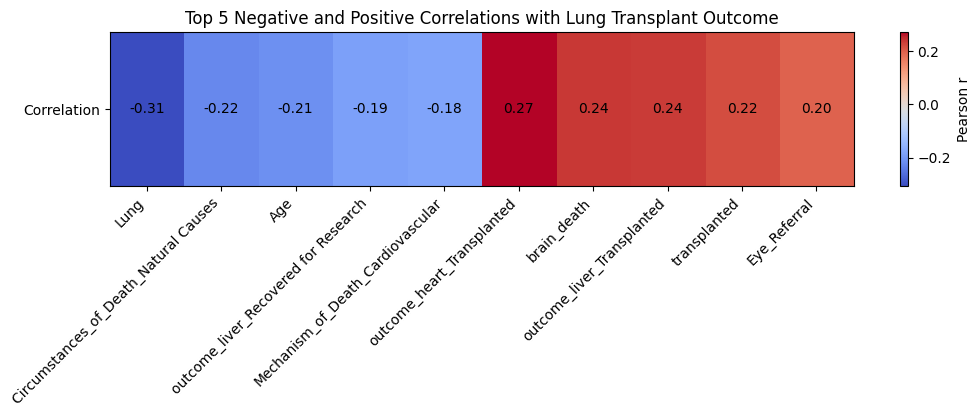

In [272]:

# Copy and drop the direct transplant & research flags plus the infection flag
df = (
    lung_eval
    .copy()
    .drop(columns=[
        'outcome_lung_left_Transplanted',
        'outcome_lung_right_Transplanted',
        'outcome_lung_right_Recovered for Research',
        'outcome_lung_left_Recovered for Research',
    ], errors='ignore')
)

# Convert boolean flags to integers so they show up in the correlation
bool_cols = df.select_dtypes(include='boolean').columns
df[bool_cols] = df[bool_cols].astype(int)

# Compute Pearson correlations with the outcome
corr = (
    df
    .select_dtypes(include=[np.number])
    .corr()['lung_transplanted']
    .drop('lung_transplanted')
)

# Select top 5 positive and top 5 negative correlations
top5_pos = corr.nlargest(5)
top5_neg = corr.nsmallest(5)
selected = pd.concat([top5_neg, top5_pos])

# Build a 1×10 DataFrame for the heatmap
heatmap_df = selected.to_frame().T

#  Plot heatmap
plt.figure(figsize=(12, 2))
plt.imshow(heatmap_df, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Pearson r')
plt.xticks(
    ticks=np.arange(heatmap_df.shape[1]),
    labels=heatmap_df.columns,
    rotation=45,
    ha='right'
)
plt.yticks([0], ['Correlation'])
for i, val in enumerate(selected.values):
    plt.text(i, 0, f"{val:.2f}", ha='center', va='center')
plt.title('Top 5 Negative and Positive Correlations with Lung Transplant Outcome')
plt.tight_layout()
plt.show()


The infection marker Lung shows a moderate negative association with actually receiving a transplant (r ≈ –0.31, p < 10⁻⁷⁸), indicating that donors flagged for infection were substantially less likely to have their lungs used. Beyond that, multi‐organ activity remains a strong positive predictor—especially heart (r ≈ +0.27, p < 10⁻⁶¹) and liver (r ≈ +0.24, p < 10⁻⁴⁶) transplants—suggesting that donors contributing multiple organs are more likely to include lungs. Donor status and circumstances also matter: brain_death donors (r ≈ +0.24, p < 10⁻⁴⁷) and deaths not due to natural causes (r ≈ +0.22 for non-natural vs. r ≈ –0.22 for natural, both p < 10⁻⁴²) each tilt the odds, as does younger age (r ≈ –0.21, p < 10⁻³⁷). A layer of microbiology flags (bronchial Gram stains, EBV IgG at r ≈ 0.13–0.16, all p < 10⁻¹⁰) and certain trauma‐related death mechanisms follow, while procedural timing and fluid volumes show only weak links (|r| < 0.06, p’s often > 10⁻⁴). In short, infection status, organ-flag indicators, and donor death characteristics are the dominant drivers of who ultimately receives a lung transplant.

#### Histograms

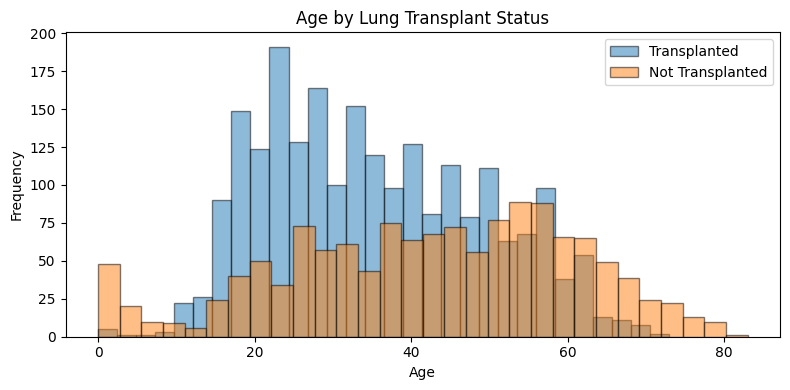

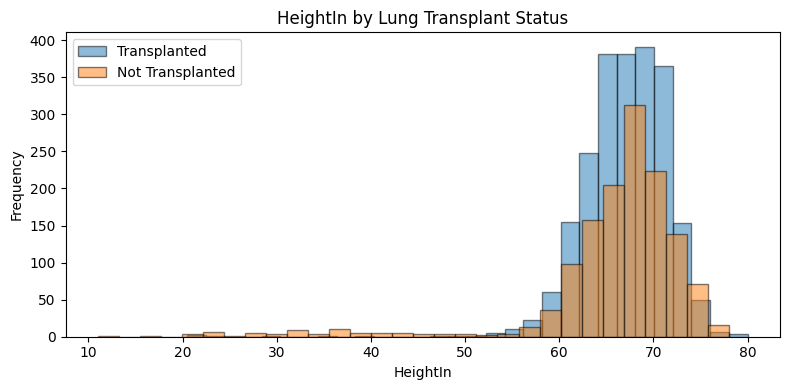

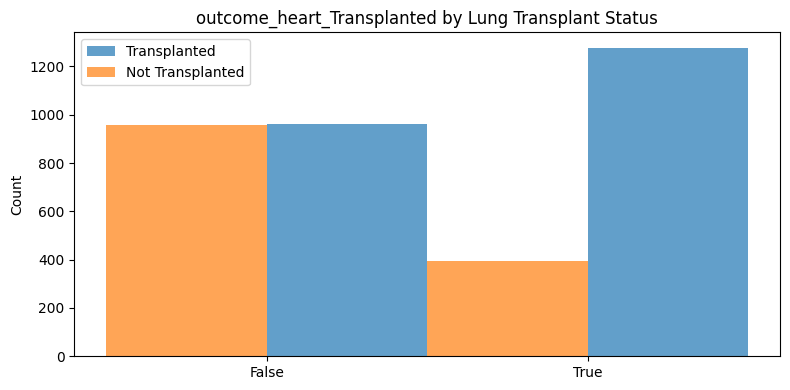

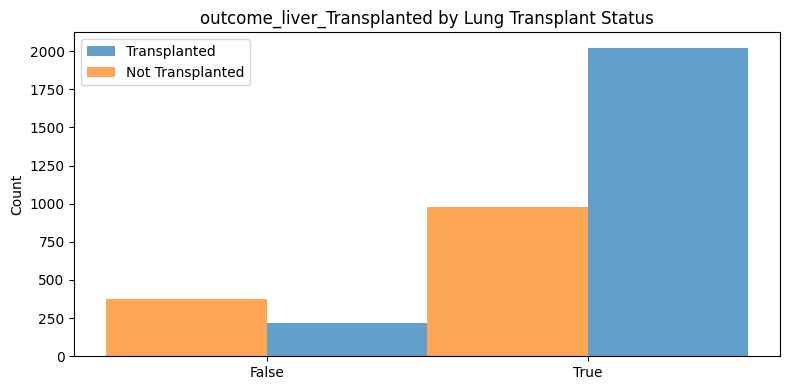

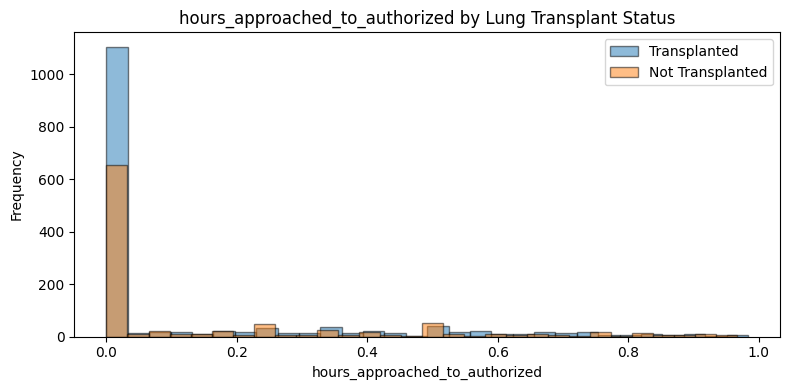

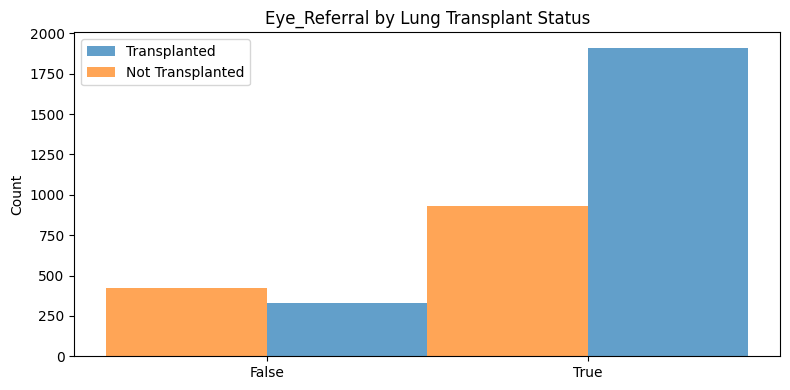

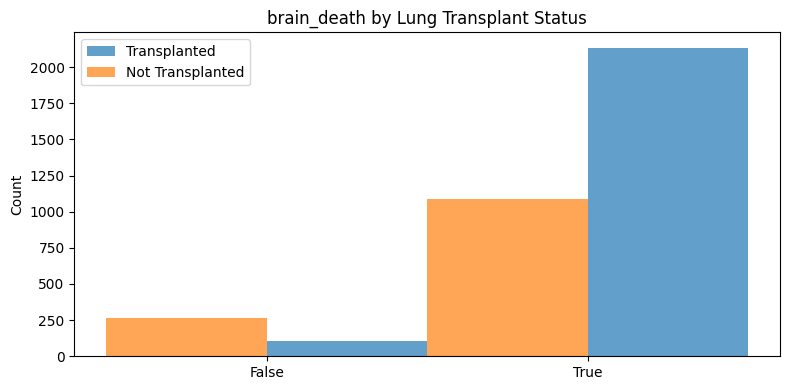

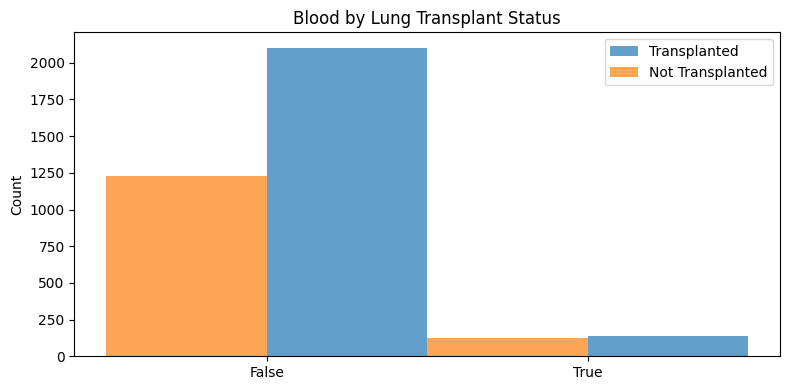

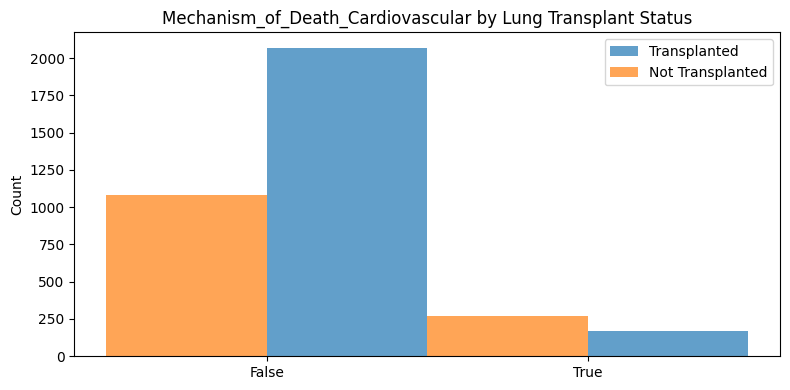

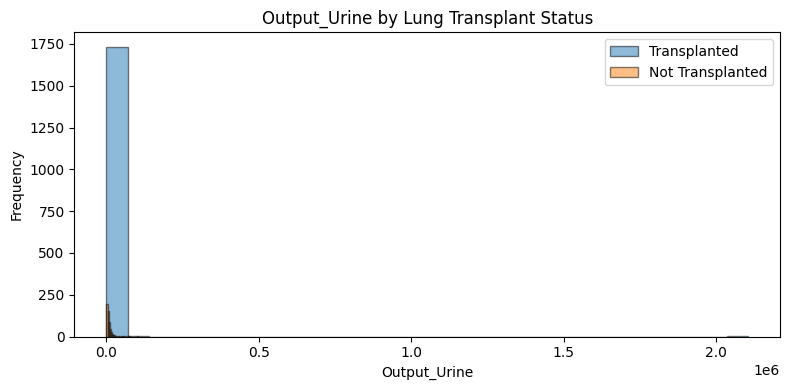

In [276]:
# Top 10 Features
features = [
    'Age',
    'HeightIn',
    'outcome_heart_Transplanted',
    'outcome_liver_Transplanted',
    'hours_approached_to_authorized',
    'Eye_Referral',
    'brain_death',
    'Blood',
    'Mechanism_of_Death_Cardiovascular',
    'Output_Urine'
]

# Prepare the DataFrame
df = lung_eval.copy()
df = df[df['lung_transplanted'].notna()]
df['lung_transplanted'] = df['lung_transplanted'].astype(int)

# Validate features exist
missing = set(features) - set(df.columns)
if missing:
    raise KeyError(f"Features not found in lung_eval: {missing}")

#  Plot histograms / bar charts by transplant status
for col in features:
    data = df.dropna(subset=[col])
    is_binary = data[col].nunique() <= 2

    plt.figure(figsize=(8, 4))
    if is_binary:
        # Bar chart of counts for each value, split by group
        for grp, label in [(1, 'Transplanted'), (0, 'Not Transplanted')]:
            grp_counts = data[data['lung_transplanted'] == grp][col].value_counts().sort_index()
            values = grp_counts.index.astype(str)
            counts = grp_counts.values
            plt.bar(
                x=np.arange(len(values)) + (0.25 if grp==1 else -0.25),
                height=counts,
                width=0.5,
                alpha=0.7,
                label=label
            )
        plt.xticks(np.arange(len(values)), values)
        plt.ylabel("Count")
    else:
        # Overlaid histograms for continuous
        bins = 30
        for grp, label in [(1, 'Transplanted'), (0, 'Not Transplanted')]:
            vals = data[data['lung_transplanted'] == grp][col]
            plt.hist(vals, bins=bins, alpha=0.5, label=label, edgecolor='black')
        plt.xlabel(col)
        plt.ylabel("Frequency")

    plt.title(f"{col} by Lung Transplant Status")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [64]:

# Prepare DataFrame
df = lung_eval.copy()
df = df[df['lung_transplanted'].notna()]
df['lung_transplanted'] = df['lung_transplanted'].astype(int)

# Identify continuous variables: numeric dtype & more than 2 unique values
num_df = df.select_dtypes(include=[np.number])
cont_vars = [
    col for col in num_df.columns
    if col != 'lung_transplanted' and num_df[col].nunique(dropna=True) > 2
]

# 3) Compute summaries & nonparametric p-values
rows = []
for var in cont_vars:
    group_not = df[df['lung_transplanted'] == 0][var].dropna()
    group_yes = df[df['lung_transplanted'] == 1][var].dropna()
    
    # Descriptive stats
    mean0, std0 = group_not.mean(), group_not.std()
    range0      = f"{group_not.min():.2f} - {group_not.max():.2f}"
    iqr0        = group_not.quantile(0.75) - group_not.quantile(0.25)
    
    mean1, std1 = group_yes.mean(), group_yes.std()
    range1      = f"{group_yes.min():.2f} - {group_yes.max():.2f}"
    iqr1        = group_yes.quantile(0.75) - group_yes.quantile(0.25)
    
    # Mann–Whitney U test
    stat, p_value = mannwhitneyu(group_yes, group_not, alternative='two-sided')
    
    rows.append({
        'feature': var,
        'not_trans_mean': mean0,
        'not_trans_std': std0,
        'not_trans_range': range0,
        'not_trans_IQR': iqr0,
        'trans_mean': mean1,
        'trans_std': std1,
        'trans_range': range1,
        'trans_IQR': iqr1,
        'p_value': p_value
    })

# 4) Create and display the summary table
summary_df = pd.DataFrame(rows)
print(summary_df.to_string(index=False))

                       feature  not_trans_mean  not_trans_std   not_trans_range  not_trans_IQR   trans_mean    trans_std       trans_range    trans_IQR      p_value
                           Age       42.328160      18.466191      0.00 - 83.00      28.000000    35.278571    13.830179      0.00 - 73.00    22.000000 2.483313e-40
                      HeightIn       65.810234       8.435899     11.02 - 78.00       6.078740    67.312123     4.558983     20.47 - 80.00     5.118110 4.731194e-02
                      WeightKg       82.113896      28.423757     0.59 - 182.73      32.000000    77.862170    18.923975     4.80 - 209.60    23.500000 2.524714e-13
                 Referral_Year     2018.025129       1.937474 2015.00 - 2021.00       4.000000  2018.288839     1.947975 2015.00 - 2021.00     3.000000 7.257767e-05
                 Procured_Year     2018.042963       1.938167 2015.00 - 2021.00       4.000000  2018.297768     1.949610 2015.00 - 2021.00     3.000000 1.239779e-04
          


Mann–Whitney U
Transplanted donors remain significantly younger (35.3 ± 13.8 y vs. 42.3 ± 18.5 y; IQR 22 y vs. 28 y; p ≈ 2.5 × 10⁻⁴⁰) and lighter (77.9 ± 18.9 kg vs. 82.1 ± 28.4 kg; IQR 23.5 kg vs. 32 kg; p ≈ 2.5 × 10⁻¹³), and still slightly taller (67.3 ± 4.6 in vs. 65.8 ± 8.4 in; IQR 5.1 in vs. 6.1 in; p ≈ 0.047). The “approached → authorized” interval is shorter in the transplant group (median 0.125 h [7.5 min] vs. 0.153 h [9.2 min]; IQR 0.15 h vs. 0.25 h; p ≈ 7.9 × 10⁻⁴), while none of the raw second‐based time measures differ significantly (all p > 0.15). Calendar‐year effects persist, with referrals occurring slightly later (2018.29 ± 1.95 vs. 2018.03 ± 1.94; IQR 3 y vs. 4 y; p ≈ 7.3 × 10⁻⁵) and procurements likewise (2018.30 ± 1.95 vs. 2018.04 ± 1.94; p ≈ 1.2 × 10⁻⁴). Fluid‐balance differences largely disappear: intake of blood products (p ≈ 0.80), colloid (p ≈ 0.24), crystalloid (p ≈ 0.69), and total fluid (p ≈ 0.29) no longer differ, and non‐urine output is similar (p ≈ 0.57). Only urine output remains higher in transplanted donors (10 102 ± 51 174 mL vs. 7 692 ± 9 552 mL; IQR 8 610 mL vs. 6 952 mL; p ≈ 1.3 × 10⁻⁴).

In [293]:
lung_eval = lung_eval.drop(columns=['time_referred'], errors='ignore')

# And when you build your analysis DataFrame for categoricals:
df = (
    lung_eval
    .copy()
    .drop(columns=['time_referred'], errors='ignore')
    .dropna(subset=['lung_transplanted'])
)
from pandas.api.types import (
    is_bool_dtype, is_object_dtype, is_categorical_dtype, is_integer_dtype
)

# Drop the raw time_referred column if present
lung_eval = lung_eval.drop(columns=['time_referred'], errors='ignore')

# Prepare a working copy and ensure the outcome is int
df = lung_eval.copy()
df = df[df['lung_transplanted'].notna()]
df['lung_transplanted'] = df['lung_transplanted'].astype(int)

# Identify all categorical columns:
#    - Any boolean dtype
#    - Any object or category dtype
#    - Any integer dtype with only two unique values (binary flags)
cat_cols = [
    c for c in df.columns
    if c != 'lung_transplanted' and (
        is_bool_dtype(df[c]) or
        is_object_dtype(df[c]) or
        is_categorical_dtype(df[c]) or
        (is_integer_dtype(df[c]) and df[c].nunique(dropna=True) == 2)
    )
]

# Function to compute Cramér’s V
def cramers_v(table):
    chi2, _, _, _ = chi2_contingency(table)
    n = table.to_numpy().sum()
    k = min(table.shape) - 1
    return np.sqrt(chi2 / (n * k)) if k > 0 else np.nan

# Loop and summarize
for col in cat_cols:
    sub = df.dropna(subset=[col])
    ct  = pd.crosstab(sub[col], sub['lung_transplanted'])
    pct = pd.crosstab(sub[col], sub['lung_transplanted'], normalize='columns') * 100

    # Build count (pct%) table
    summary = ct.astype(str) + " (" + pct.round(1).astype(str) + "%)"
    summary.columns = ['Not Transplanted', 'Transplanted']

    # χ² test & Cramér’s V
    chi2, p, _, _ = chi2_contingency(ct)
    v = cramers_v(ct)

    print(f"\n=== {col} ===")
    print(summary.to_string())
    print(f"χ² p-value: {p:.3g}    Cramér’s V: {v:.3f}")

C:\Users\chris\AppData\Local\Temp\ipykernel_27412\82155244.py:31: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_categorical_dtype(df[c]) or



=== OPO ===
     Not Transplanted Transplanted
OPO                               
OPO1      232 (17.1%)  727 (32.5%)
OPO2        88 (6.5%)   177 (7.9%)
OPO3        49 (3.6%)   116 (5.2%)
OPO4      789 (58.3%)  499 (22.3%)
OPO5       118 (8.7%)  414 (18.5%)
OPO6        77 (5.7%)  307 (13.7%)
χ² p-value: 5.98e-104    Cramér’s V: 0.370

=== Gender ===
       Not Transplanted  Transplanted
Gender                               
False       516 (38.1%)   893 (39.9%)
True        837 (61.9%)  1347 (60.1%)
χ² p-value: 0.321    Cramér’s V: 0.017

=== brain_death ===
            Not Transplanted  Transplanted
brain_death                               
False            266 (19.7%)    106 (4.7%)
True            1087 (80.3%)  2134 (95.3%)
χ² p-value: 1.32e-45    Cramér’s V: 0.236

=== approached ===
           Not Transplanted  Transplanted
approached                               
False              1 (0.1%)      3 (0.1%)
True           1352 (99.9%)  2237 (99.9%)
χ² p-value: 0.995    Cramér’s V: 0

Overall, the most powerful categorical predictors of lung utilization remain the procurement region, multi‐organ donation flags, donor death status, and infection markers. In particular, lungs from OPO1 were used in 32.5 % of cases versus 17.1 % elsewhere (Cramér’s V ≈ 0.37, χ² p ≈ 6 × 10⁻¹⁰⁴), and donors who also contributed hearts (V ≈ 0.27, p ≈ 9.5 × 10⁻⁵⁹) or livers (V ≈ 0.24, p ≈ 5.6 × 10⁻⁴⁵) were far more likely to have lungs transplanted. Brain‐death donors accounted for 95.3 % of transplanted lungs versus 80.3 % of non-transplants (V ≈ 0.24, p ≈ 1.3 × 10⁻⁴⁵), while lungs flagged as infected were used only 18.3 % of the time versus 47.1 % when unflagged (V ≈ 0.31, p ≈ 5.6 × 10⁻⁷⁵). Secondary culture findings—bronchial Gram‐stains (V ≈ 0.15, p < 10⁻¹⁹), sputum cultures (V ≈ 0.12, p < 10⁻¹¹)—and referral activity (eye V ≈ 0.19, p ≈ 2 × 10⁻³¹; tissue V ≈ 0.15, p ≈ 3 × 10⁻¹⁸) showed more modest but still significant associations. All were evaluated via Pearson’s χ² tests with effect sizes reported by Cramér’s V.

# Modeling

### Neural Network


In [70]:

# Drop unwanted columns
drop_cols = [
    'outcome_lung_left_Transplanted',
    'outcome_lung_right_Transplanted',
    'outcome_lung_right_Recovered for Research',
    'outcome_lung_left_Recovered for Research',
    'time_referred',
]
df = lung_eval.copy().drop(columns=drop_cols, errors='ignore')

# Ensure target is integer 0/1
df = df[df['lung_transplanted'].notna()]
df['lung_transplanted'] = df['lung_transplanted'].astype(int)

# Separate features and target
y = df.pop('lung_transplanted')
X = df.copy()

# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include=['boolean', 'object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()

# One-hot encode categoricals
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Scale numeric columns
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Build the neural network
n_features = X_train.shape[1]
model = models.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Train with early stopping
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

# Evaluate on the test set
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.3f},  Test AUC: {test_auc:.3f}")

# Detailed classification report
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Epoch 1/100
72/72 - 5s - 72ms/step - accuracy: 0.6146 - auc: 0.4940 - loss: 0.6898 - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: 0.6864
Epoch 2/100
72/72 - 1s - 11ms/step - accuracy: 0.6229 - auc: 0.4968 - loss: 0.6838 - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: 0.6807
Epoch 3/100
72/72 - 1s - 18ms/step - accuracy: 0.6229 - auc: 0.5119 - loss: 0.6789 - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: 0.6763
Epoch 4/100
72/72 - 1s - 18ms/step - accuracy: 0.6229 - auc: 0.5247 - loss: 0.6750 - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: 0.6728
Epoch 5/100
72/72 - 1s - 19ms/step - accuracy: 0.6229 - auc: 0.4920 - loss: 0.6720 - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: 0.6698
Epoch 6/100
72/72 - 1s - 18ms/step - accuracy: 0.6229 - auc: 0.4973 - loss: 0.6697 - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: 0.6679
Epoch 7/100
72/72 - 1s - 18ms/step - accuracy: 0.6229 - auc: 0.4757 - loss: 0.6680 - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: 0.6661

C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


NN has memorized the majority

#### Tune compute per‐class weights

In [73]:

# Drop unwanted columns
drop_cols = [
    'outcome_lung_left_Transplanted',
    'outcome_lung_right_Transplanted',
    'outcome_lung_right_Recovered for Research',
    'outcome_lung_left_Recovered for Research',
    'time_referred',
]
df = lung_eval.copy().drop(columns=drop_cols, errors='ignore')

# Ensure target is integer 0/1
df = df[df['lung_transplanted'].notna()]
df['lung_transplanted'] = df['lung_transplanted'].astype(int)

# Separate features and target
y = df.pop('lung_transplanted')
X = df.copy()

# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include=['boolean', 'object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()

# One-hot encode categoricals
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Scale numeric columns
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Compute class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(weights))

# Build the neural network
n_features = X_train.shape[1]
model = models.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Train with early stopping and class weights
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=2
)

# Evaluate on the test set
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.3f},  Test AUC: {test_auc:.3f}")

# Detailed classification report
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Epoch 1/100
72/72 - 5s - 64ms/step - accuracy: 0.5485 - auc: 0.5006 - loss: 0.6933 - val_accuracy: 0.3739 - val_auc: 0.5000 - val_loss: 0.6932
Epoch 2/100
72/72 - 2s - 28ms/step - accuracy: 0.3771 - auc: 0.5000 - loss: 0.6934 - val_accuracy: 0.3739 - val_auc: 0.5000 - val_loss: 0.6934
Epoch 3/100
72/72 - 1s - 11ms/step - accuracy: 0.4206 - auc: 0.5000 - loss: 0.6934 - val_accuracy: 0.3739 - val_auc: 0.5000 - val_loss: 0.6938
Epoch 4/100
72/72 - 1s - 18ms/step - accuracy: 0.4472 - auc: 0.5000 - loss: 0.6934 - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: 0.6929
Epoch 5/100
72/72 - 1s - 17ms/step - accuracy: 0.4772 - auc: 0.5000 - loss: 0.6934 - val_accuracy: 0.3739 - val_auc: 0.5000 - val_loss: 0.6935
Epoch 6/100
72/72 - 1s - 18ms/step - accuracy: 0.3771 - auc: 0.5000 - loss: 0.6934 - val_accuracy: 0.3739 - val_auc: 0.5000 - val_loss: 0.6936
Epoch 7/100
72/72 - 1s - 18ms/step - accuracy: 0.3771 - auc: 0.5000 - loss: 0.6934 - val_accuracy: 0.3739 - val_auc: 0.5000 - val_loss: 0.6933

C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


the network has completely collapsed to predicting only the “not transplanted” class (0):

 #### Tuning: training on a balanced (upsampled)

In [76]:

# Drop unwanted columns
drop_cols = [
    'outcome_lung_left_Transplanted',
    'outcome_lung_right_Transplanted',
    'outcome_lung_right_Recovered for Research',
    'outcome_lung_left_Recovered for Research',
    'time_referred',
]
df = lung_eval.copy().drop(columns=drop_cols, errors='ignore')

# Keep only complete target rows and cast to int
df = df[df['lung_transplanted'].notna()]
df['lung_transplanted'] = df['lung_transplanted'].astype(int)

# Split features and target
y = df.pop('lung_transplanted')
X = df.copy()

# One-hot encode categoricals & scale numerics
cat_cols = X.select_dtypes(include=['boolean','object','category']).columns
num_cols = X.select_dtypes(include=['number']).columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# UPSAMPLE minority class in training set
train = X_train.copy()
train['lung_transplanted'] = y_train
majority = train[train.lung_transplanted==1]
minority = train[train.lung_transplanted==0]
minority_up = resample(minority,
                       replace=True,
                       n_samples=len(majority),
                       random_state=42)
train_bal = pd.concat([majority, minority_up])
y_train_bal = train_bal.pop('lung_transplanted')
X_train_bal = train_bal

# Build NN
n_features = X_train_bal.shape[1]
model = models.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Train with early stopping
early_stop = callbacks.EarlyStopping(monitor='val_loss',
                                     patience=5,
                                     restore_best_weights=True)
history = model.fit(
    X_train_bal, y_train_bal,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

# Evaluate
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.3f},  Test AUC: {test_auc:.3f}")
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Epoch 1/100
90/90 - 5s - 52ms/step - accuracy: 0.6205 - auc: 0.4984 - loss: 0.6819 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.8127
Epoch 2/100
90/90 - 1s - 11ms/step - accuracy: 0.6250 - auc: 0.4994 - loss: 0.6662 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.9224
Epoch 3/100
90/90 - 1s - 13ms/step - accuracy: 0.6250 - auc: 0.4838 - loss: 0.6643 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.9464
Epoch 4/100
90/90 - 1s - 10ms/step - accuracy: 0.6250 - auc: 0.5092 - loss: 0.6620 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.9599
Epoch 5/100
90/90 - 1s - 14ms/step - accuracy: 0.6250 - auc: 0.5030 - loss: 0.6623 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.9714
Epoch 6/100
90/90 - 1s - 12ms/step - accuracy: 0.6250 - auc: 0.4959 - loss: 0.6628 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.9678
Test accuracy: 0.623,  Test AUC: 0.500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              pr

C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 always predicting the majority class (“transplanted”), the network minimizes its loss function but learns nothing useful about the distinction

In [78]:
#### Tune: Adjust Architecture (deeper)

In [79]:

# Prepare data
drop_cols = [
    'outcome_lung_left_Transplanted',
    'outcome_lung_right_Transplanted',
    'outcome_lung_right_Recovered for Research',
    'outcome_lung_left_Recovered for Research',
    'time_referred',
    'Referral_Year'   # <-- dropped due to high VIF
]

df = lung_eval.copy().drop(columns=drop_cols, errors='ignore')
df = df[df['lung_transplanted'].notna()]
df['lung_transplanted'] = df['lung_transplanted'].astype(int)

y = df.pop('lung_transplanted')
X = df.copy()

# Encode & scale
cat_cols = X.select_dtypes(include=['boolean', 'object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()

X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Build a deeper NN
n_features = X_train.shape[1]
model = models.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(64,  activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32,  activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1,   activation='sigmoid'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Train with early stopping
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

# Evaluate
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.3f}, Test AUC: {test_auc:.3f}")

y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Epoch 1/100
72/72 - 5s - 73ms/step - accuracy: 0.6220 - auc: 0.5103 - loss: 0.6895 - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: 0.6860
Epoch 2/100
72/72 - 2s - 24ms/step - accuracy: 0.6229 - auc: 0.5146 - loss: 0.6834 - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: 0.6806
Epoch 3/100
72/72 - 1s - 12ms/step - accuracy: 0.6229 - auc: 0.4939 - loss: 0.6787 - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: 0.6759
Epoch 4/100
72/72 - 1s - 20ms/step - accuracy: 0.6229 - auc: 0.5081 - loss: 0.6749 - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: 0.6726
Epoch 5/100
72/72 - 1s - 19ms/step - accuracy: 0.6229 - auc: 0.5041 - loss: 0.6719 - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: 0.6700
Epoch 6/100
72/72 - 1s - 18ms/step - accuracy: 0.6229 - auc: 0.4982 - loss: 0.6696 - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: 0.6676
Epoch 7/100
72/72 - 1s - 15ms/step - accuracy: 0.6229 - auc: 0.4934 - loss: 0.6678 - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: 0.6660

C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Even with more layers and after removing collinear inputs, the network isn’t finding any signal that generalizes beyond simply guessing the majority label.

#### Tuning: Adjust Balance

In [82]:

# Prepare data
drop_cols = [
    'outcome_lung_left_Transplanted',
    'outcome_lung_right_Transplanted',
    'outcome_lung_right_Recovered for Research',
    'outcome_lung_left_Recovered for Research',
    'time_referred',
    'Referral_Year'
]
df = lung_eval.copy().drop(columns=drop_cols, errors='ignore')
df = df[df['lung_transplanted'].notna()]
df['lung_transplanted'] = df['lung_transplanted'].astype(int)

y = df.pop('lung_transplanted')
X = df.copy()

# Identify categorical and numeric features
cat_cols = X.select_dtypes(include=['boolean','object','category']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()

# One-hot encode categoricals and scale numerics
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Compute class weights to rebalance
classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight = dict(zip(classes, weights))

# Build the neural network
n_features = X_train.shape[1]
model = models.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Train with early stopping and class weights
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=2
)

# Evaluate on the test set
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.3f}, Test AUC: {test_auc:.3f}")

# Detailed metrics
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Epoch 1/100
72/72 - 5s - 75ms/step - accuracy: 0.6237 - auc: 0.5007 - loss: 0.6935 - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: 0.6909
Epoch 2/100
72/72 - 2s - 24ms/step - accuracy: 0.3884 - auc: 0.4825 - loss: 0.6936 - val_accuracy: 0.3739 - val_auc: 0.5000 - val_loss: 0.6939
Epoch 3/100
72/72 - 1s - 12ms/step - accuracy: 0.3771 - auc: 0.5000 - loss: 0.6934 - val_accuracy: 0.3739 - val_auc: 0.5000 - val_loss: 0.6939
Epoch 4/100
72/72 - 1s - 18ms/step - accuracy: 0.3771 - auc: 0.5000 - loss: 0.6934 - val_accuracy: 0.3739 - val_auc: 0.5000 - val_loss: 0.6937
Epoch 5/100
72/72 - 1s - 12ms/step - accuracy: 0.3771 - auc: 0.4859 - loss: 0.6934 - val_accuracy: 0.3739 - val_auc: 0.5000 - val_loss: 0.6938
Epoch 6/100
72/72 - 1s - 12ms/step - accuracy: 0.3893 - auc: 0.5000 - loss: 0.6934 - val_accuracy: 0.3739 - val_auc: 0.5000 - val_loss: 0.6939
Test accuracy: 0.623, Test AUC: 0.500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
              precision    recall  f1-score   support

         

C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


No real change

#### Tune: Regularization

In [85]:

# 1. Data prep
drop_cols = [
    'outcome_lung_left_Transplanted',
    'outcome_lung_right_Transplanted',
    'outcome_lung_right_Recovered for Research',
    'outcome_lung_left_Recovered for Research',
    'time_referred',
    'Referral_Year'
]
df = lung_eval.copy().drop(columns=drop_cols, errors='ignore')
df = df[df['lung_transplanted'].notna()]
df['lung_transplanted'] = df['lung_transplanted'].astype(int)

y = df.pop('lung_transplanted')
X = df.copy()

cat_cols = X.select_dtypes(include=['boolean','object','category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 2. Model with stronger regularization
n_features = X_train.shape[1]
model = models.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(128,
                 activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(64,
                 activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# 3. Training
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

# 4. Evaluation
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.3f},  Test AUC: {test_auc:.3f}")

y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Epoch 1/100
72/72 - 6s - 78ms/step - accuracy: 0.6177 - auc: 0.4980 - loss: nan - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: nan
Epoch 2/100
72/72 - 1s - 12ms/step - accuracy: 0.6229 - auc: 0.4843 - loss: nan - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: nan
Epoch 3/100
72/72 - 1s - 19ms/step - accuracy: 0.6229 - auc: 0.4896 - loss: nan - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: nan
Epoch 4/100
72/72 - 1s - 18ms/step - accuracy: 0.6229 - auc: 0.4969 - loss: nan - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: nan
Epoch 5/100
72/72 - 1s - 18ms/step - accuracy: 0.6229 - auc: 0.4938 - loss: nan - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: nan
Epoch 6/100
72/72 - 1s - 18ms/step - accuracy: 0.6229 - auc: 0.4945 - loss: nan - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: nan
Epoch 7/100
72/72 - 1s - 18ms/step - accuracy: 0.6229 - auc: 0.5074 - loss: nan - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: nan
Epoch 8/100
72/72 - 1s - 18ms/step - accu

C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Tune:Change the loss fxn

In [94]:

# Drop unwanted columns
drop_cols = [
    'outcome_lung_left_Transplanted',
    'outcome_lung_right_Transplanted',
    'outcome_lung_right_Recovered for Research',
    'outcome_lung_left_Recovered for Research',
    'referral_year'    # we’ve dropped this to address multicollinearity
]
df = lung_eval.copy().drop(columns=drop_cols, errors='ignore')

# Filter & encode target
df = df[df['lung_transplanted'].notna()]
df['lung_transplanted'] = df['lung_transplanted'].astype(int)

# Split features / target
y = df.pop('lung_transplanted')
X = df.copy()

# One-hot encode categoricals
cat_cols = X.select_dtypes(include=['boolean','object','category']).columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Scale numerics
num_cols = X.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Build the network
n_features = X_train.shape[1]
model = keras.models.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid'),
])

# Compile with focal loss
model.compile(
    optimizer='adam',
    loss=BinaryFocalCrossentropy(gamma=2.0, alpha=0.25),
    metrics=['accuracy', AUC(name='auc')]
)

# Early stopping
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

# Evaluate
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.3f},  Test AUC: {test_auc:.3f}")

# Detailed metrics
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


Epoch 1/100
72/72 - 5s - 70ms/step - accuracy: 0.6211 - auc: 0.5126 - loss: nan - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: nan
Epoch 2/100
72/72 - 2s - 25ms/step - accuracy: 0.6229 - auc: 0.4981 - loss: nan - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: nan
Epoch 3/100
72/72 - 1s - 12ms/step - accuracy: 0.6229 - auc: 0.5015 - loss: nan - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: nan
Epoch 4/100
72/72 - 1s - 17ms/step - accuracy: 0.6229 - auc: 0.5000 - loss: nan - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: nan
Epoch 5/100
72/72 - 1s - 20ms/step - accuracy: 0.6229 - auc: 0.4960 - loss: nan - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: nan
Epoch 6/100
72/72 - 1s - 16ms/step - accuracy: 0.6229 - auc: 0.5067 - loss: nan - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: nan
Test accuracy: 0.623,  Test AUC: 0.500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

           0      0.000     0.000     0.000  

C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


No change

## Feed Foward NN

In [96]:

# Prepare df
drop_cols = [
    'outcome_lung_left_Transplanted',
    'outcome_lung_right_Transplanted',
    'outcome_lung_right_Recovered for Research',
    'outcome_lung_left_Recovered for Research',
    'time_referred',
]
df = lung_eval.copy().drop(columns=drop_cols, errors='ignore')
df = df[df['lung_transplanted'].notna()]
df['lung_transplanted'] = df['lung_transplanted'].astype(int)

# Split target/features
y = df.pop('lung_transplanted')
X = df.copy()

# One-hot + scale
cat_cols = X.select_dtypes(include=['boolean','object','category']).columns
num_cols = X.select_dtypes(include=['number']).columns

X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 1) sanitize column names
safe_cols = (
    X_train.columns
    .to_series()
    .str.replace(r'[^0-9A-Za-z_]', '_', regex=True)
)
X_train.columns = safe_cols
X_test.columns  = safe_cols  # keep them aligned

# 2) force numeric dtype
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

# Build the neural network
n_features = X_train.shape[1]
model = models.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Early stopping
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

# Evaluate
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.3f},  Test AUC: {test_auc:.3f}")

# Classification report
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Epoch 1/100
72/72 - 5s - 71ms/step - accuracy: 0.6116 - auc: 0.5080 - loss: 0.6896 - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: 0.6862
Epoch 2/100
72/72 - 2s - 26ms/step - accuracy: 0.6229 - auc: 0.4796 - loss: 0.6837 - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: 0.6807
Epoch 3/100
72/72 - 1s - 14ms/step - accuracy: 0.6229 - auc: 0.4856 - loss: 0.6789 - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: 0.6762
Epoch 4/100
72/72 - 1s - 16ms/step - accuracy: 0.6229 - auc: 0.4900 - loss: 0.6751 - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: 0.6728
Epoch 5/100
72/72 - 1s - 18ms/step - accuracy: 0.6229 - auc: 0.4988 - loss: 0.6721 - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: 0.6700
Epoch 6/100
72/72 - 1s - 18ms/step - accuracy: 0.6229 - auc: 0.4972 - loss: 0.6697 - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: 0.6679
Epoch 7/100
72/72 - 1s - 18ms/step - accuracy: 0.6229 - auc: 0.4848 - loss: 0.6679 - val_accuracy: 0.6261 - val_auc: 0.5000 - val_loss: 0.6661

C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


No change

## Random Forrest

In [98]:

# Prepare data (exactly as before)
drop_cols = [
    'outcome_lung_left_Transplanted',
    'outcome_lung_right_Transplanted',
    'outcome_lung_right_Recovered for Research',
    'outcome_lung_left_Recovered for Research',
    'time_referred',
]
df = lung_eval.copy().drop(columns=drop_cols, errors='ignore')
df = df[df['lung_transplanted'].notna()]
df['lung_transplanted'] = df['lung_transplanted'].astype(int)

y = df.pop('lung_transplanted')
X = df.copy()

# One-hot encode categoricals
cat_cols = X.select_dtypes(include=['boolean','object','category']).columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Scale numerics
num_cols = X.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Fit a balanced Random Forest
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    class_weight='balanced',   # automatically weights classes
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Evaluate
y_proba = model.predict_proba(X_test)[:,1]
y_pred  = model.predict(X_test)
print(f"Test AUC: {roc_auc_score(y_test, y_proba):.3f}\n")
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Test AUC: 0.849

              precision    recall  f1-score   support

           0      0.696     0.720     0.708       271
           1      0.827     0.810     0.818       448

    accuracy                          0.776       719
   macro avg      0.762     0.765     0.763       719
weighted avg      0.778     0.776     0.777       719

Confusion matrix:
 [[195  76]
 [ 85 363]]


#### Feature Importance

In [100]:
feat_imp = pd.Series(model.feature_importances_, index=X_train.columns)
print(feat_imp.sort_values(ascending=False).head(10))


Output_NonUrine                    0.060851
Intake_Colloid                     0.054460
Age                                0.053331
Output_Urine                       0.047225
Intake_BloodProduct                0.046912
outcome_heart_Transplanted_True    0.045035
WeightKg                           0.038386
Intake_Crystalloid                 0.034118
OPO_OPO4                           0.031935
Intake_Total                       0.030574
dtype: float64


## XGboost

In [102]:

# Load / copy your cleaned dataframe
df = lung_eval.copy()

# Drop the unwanted lung‐outcome and raw time cols
drop_cols = [
    'outcome_lung_left_Transplanted',
    'outcome_lung_right_Transplanted',
    'outcome_lung_right_Recovered for Research',
    'outcome_lung_left_Recovered for Research',
    'time_referred'
]
df = df.drop(columns=drop_cols, errors='ignore')

# Keep only rows where target exists, and cast to int
df = df[df['lung_transplanted'].notna()]
df['lung_transplanted'] = df['lung_transplanted'].astype(int)

# Split out X and y
y = df.pop('lung_transplanted')
X = df.copy()

# One-hot encode all categorical/boolean cols
cat_cols = X.select_dtypes(include=['boolean','object','category']).columns.tolist()
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Scale numeric features
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Fit XGBoost
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    tree_method="hist"          
)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

# Evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(f"Test accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Test AUC:      {roc_auc_score(y_test, y_proba):.3f}\n")

print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

[0]	validation_0-logloss:0.63307
[1]	validation_0-logloss:0.60925
[2]	validation_0-logloss:0.58829
[3]	validation_0-logloss:0.57047
[4]	validation_0-logloss:0.55708
[5]	validation_0-logloss:0.54388
[6]	validation_0-logloss:0.53295
[7]	validation_0-logloss:0.52231
[8]	validation_0-logloss:0.51248
[9]	validation_0-logloss:0.50425
[10]	validation_0-logloss:0.49738
[11]	validation_0-logloss:0.49116
[12]	validation_0-logloss:0.48601
[13]	validation_0-logloss:0.48101


C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\xgboost\core.py:158: UserWarning: [19:29:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-logloss:0.47617
[15]	validation_0-logloss:0.47299
[16]	validation_0-logloss:0.47034
[17]	validation_0-logloss:0.46641
[18]	validation_0-logloss:0.46443
[19]	validation_0-logloss:0.46141
[20]	validation_0-logloss:0.45906
[21]	validation_0-logloss:0.45620
[22]	validation_0-logloss:0.45431
[23]	validation_0-logloss:0.45249
[24]	validation_0-logloss:0.44963
[25]	validation_0-logloss:0.44801
[26]	validation_0-logloss:0.44554
[27]	validation_0-logloss:0.44374
[28]	validation_0-logloss:0.44330
[29]	validation_0-logloss:0.44241
[30]	validation_0-logloss:0.44064
[31]	validation_0-logloss:0.43923
[32]	validation_0-logloss:0.43787
[33]	validation_0-logloss:0.43750
[34]	validation_0-logloss:0.43724
[35]	validation_0-logloss:0.43625
[36]	validation_0-logloss:0.43604
[37]	validation_0-logloss:0.43500
[38]	validation_0-logloss:0.43481
[39]	validation_0-logloss:0.43460
[40]	validation_0-logloss:0.43373
[41]	validation_0-logloss:0.43292
[42]	validation_0-logloss:0.43260
[43]	validatio

#### Tune: Hyperparameter Tuning

In [109]:

# define parameter distributions
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}

# wrap the existing model
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method='hist',
    random_state=42
)

# randomized search
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print(f"CV AUC: {search.best_score_:.3f}")

# evaluate best model on test set
best = search.best_estimator_
y_pred = best.predict(X_test)
y_proba = best.predict_proba(X_test)[:,1]

print(f"Test accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Test AUC:      {roc_auc_score(y_test, y_proba):.3f}")
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\xgboost\core.py:158: UserWarning: [19:31:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best params: {'colsample_bytree': 0.6220627611238871, 'gamma': 0.8414552108646528, 'learning_rate': 0.07562926587192106, 'max_depth': 3, 'n_estimators': 229, 'reg_alpha': 0.363629602379294, 'reg_lambda': 0.9717820827209607, 'subsample': 0.9812236474710556}
CV AUC: 0.862
Test accuracy: 0.821
Test AUC:      0.869
              precision    recall  f1-score   support

           0      0.791     0.712     0.750       271
           1      0.836     0.886     0.860       448

    accuracy                          0.821       719
   macro avg      0.813     0.799     0.805       719
weighted avg      0.819     0.821     0.819       719

Confusion matrix:
 [[193  78]
 [ 51 397]]


Top 20 feature importances by gain:
                                                              feature      gain
                                                       Intake_Colloid 53.989784
                                      outcome_heart_Transplanted_True 52.704166
                                                  Intake_BloodProduct 36.732849
                                                   Intake_Crystalloid 30.294910
                                                     brain_death_True 22.533138
                                                      Race_Other_True 22.195395
                                                    transplanted_True 16.875126
outcome_lung_right_Recovered for Transplant but not Transplanted_True 16.681974
                                                                  Age 15.531398
                               Mechanism_of_Death_Cardiovascular_True 13.427661
                            outcome_liver_Recovered for Research_True 11.971889
    

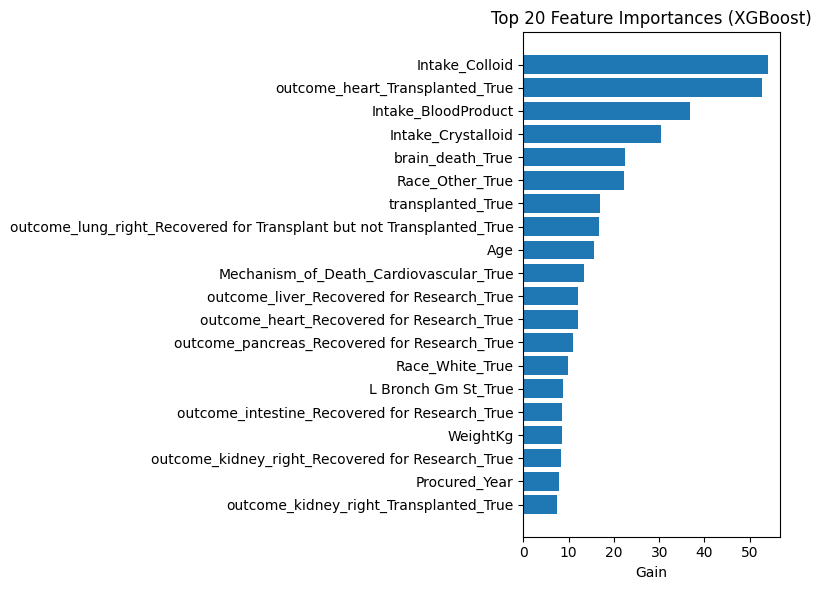

In [111]:

# Pull out feature importance by gain
booster = model.get_booster()
importance_dict = booster.get_score(importance_type='gain')

# Build a DataFrame and sort
importance_df = pd.DataFrame({
    'feature': list(importance_dict.keys()),
    'gain':    list(importance_dict.values())
})
importance_df = importance_df.sort_values('gain', ascending=False).reset_index(drop=True)

# Show top 20 in a table
print("Top 20 feature importances by gain:")
print(importance_df.head(20).to_string(index=False))

# Plot them
top_n = 20
top20 = importance_df.head(top_n)
plt.figure(figsize=(8, 6))
plt.barh(top20['feature'][::-1], top20['gain'][::-1])
plt.xlabel('Gain')
plt.title(f'Top {top_n} Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()

The top‐ranked predictors from the XGBoost “gain” importances paint a clear picture of what’s driving the model’s lung‐use decisions:

Peri‐procurement fluid volumes dominate. Colloid infusion is by far the single most influential continuous variable, followed closely by total blood‐product and crystalloid volumes. This suggests that donors who receive larger fluid resuscitation loads (or perhaps whose clinical courses necessitate them) have markedly different lung‐use outcomes.

Multi‐organ transplant flags carry tremendous weight: a heart‐transplanted indicator is essentially tied for second, and liver‐recovery flags also appear in the top dozen. Donors whose hearts (and to a lesser extent livers) go to transplant are far more likely also to contribute usable lungs.

Brain‐death status remains a key binary split: lungs from brain‐dead donors are used far more often than from non–brain‐dead cases.

Demographics and culture markers round out the top twenty: “Race = Other” (vs. White/Black/Hispanic), donor age, and bronchial‐Gram‐stain positivity all make the cut, implying both biological and system‐level (regional referral) effects.

Smaller effects beyond those include pancreas‐ and intestine‐research recovery flags, overall procurement year (capturing temporal trends), and donor weight.

In short, our model leans heavily on peridonation fluid management and the presence of other organ transplant flags, with brain‐death and a handful of demographic/culture covariates playing secondary roles.

In [119]:


# your best XGB params from tuning
xgb_params = {
    'colsample_bytree': 0.6220627611238871,
    'gamma': 0.8414552108646528,
    'learning_rate': 0.07562926587192106,
    'max_depth': 3,
    'n_estimators': 229,
    'reg_alpha': 0.363629602379294,
    'reg_lambda': 0.9717820827209607,
    'subsample': 0.9812236474710556,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'tree_method': 'hist',
    'random_state': 42
}

# define base learners
hgb = HistGradientBoostingClassifier(
    max_iter=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

xgb = XGBClassifier(**xgb_params)

rfc = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

# pipeline: impute → soft‐voting ensemble
ensemble = make_pipeline(
    SimpleImputer(strategy="median"),
    VotingClassifier(
        estimators=[("hgb", hgb), ("xgb", xgb), ("rf", rfc)],
        voting="soft",
        n_jobs=-1
    )
)

# fit & evaluate
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)
y_proba = ensemble.predict_proba(X_test)[:, 1]

print(f"Test AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


Test AUC: 0.872
              precision    recall  f1-score   support

           0      0.797     0.679     0.733       271
           1      0.822     0.895     0.857       448

    accuracy                          0.814       719
   macro avg      0.809     0.787     0.795       719
weighted avg      0.812     0.814     0.810       719

Confusion matrix:
 [[184  87]
 [ 47 401]]


#### Tune: Threshold

In [128]:
# Get predicted probabilities for the positive class
y_proba = ensemble.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Find threshold that maximizes tpr - fpr (Youden’s J)
j_scores = tpr - fpr
ix = j_scores.argmax()
best_thresh = thresholds[ix]
print(f"Best threshold by Youden’s J: {best_thresh:.3f} (TPR {tpr[ix]:.3f}, FPR {fpr[ix]:.3f})")

# Apply threshold and re-evaluate
y_pred_thresh = (y_proba >= best_thresh).astype(int)

print("Classification at custom threshold:")
print(classification_report(y_test, y_pred_thresh, digits=3))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_thresh))

Best threshold by Youden’s J: 0.624 (TPR 0.844, FPR 0.207)
Classification at custom threshold:
              precision    recall  f1-score   support

           0      0.754     0.793     0.773       271
           1      0.871     0.844     0.857       448

    accuracy                          0.825       719
   macro avg      0.813     0.819     0.815       719
weighted avg      0.827     0.825     0.826       719

Confusion matrix:
[[215  56]
 [ 70 378]]


#### Check Calibration

In [141]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# an imputer step for all learners
imputer = SimpleImputer(strategy="median")

#  three learners, each wrapped in its own Pipeline
hgb_pipe = Pipeline([
    ("imputer", imputer),
    ("hgb", HistGradientBoostingClassifier(
        max_iter=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ))
])

xgb_pipe = Pipeline([
    ("imputer", imputer),
    ("xgb", XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        tree_method="hist",
        random_state=42,
        # if you want, inject your tuned best_params here:
        # **best_params
    ))
])

svc_pipe = Pipeline([
    ("imputer", imputer),
    ("svc", SVC(
        probability=True,
        kernel="rbf",
        C=1.0,
        gamma="scale",
        random_state=42
    ))
])

# soft-voting ensemble
voting_clf = VotingClassifier(
    estimators=[
        ("hgb", hgb_pipe),
        ("xgb", xgb_pipe),
        ("svc", svc_pipe)
    ],
    voting="soft",    # average predicted probabilities
    n_jobs=-1
)

# fit on your original training split
voting_clf.fit(X_train, y_train)

# now you can calibrate, threshold, or predict as before without
# hitting the “contains NaN” error


VotingClassifier(estimators=[('hgb',
                              Pipeline(steps=[('imputer',
                                               SimpleImputer(strategy='median')),
                                              ('hgb',
                                               HistGradientBoostingClassifier(max_depth=3,
                                                                              random_state=42))])),
                             ('xgb',
                              Pipeline(steps=[('imputer',
                                               SimpleImputer(strategy='median')),
                                              ('xgb',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             cols...
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...))])),
                             ('svc',
                              Pipeline(steps=[('imputer',
                                               SimpleImputer(strategy='median')),
                                              ('svc',
                                               SVC(probability=True,
                                                   random_state=42))]))],
                 n_jobs=-1, voting='soft')

In [146]:
from sklearn.metrics import (
    accuracy_score, roc_auc_score,
    classification_report, confusion_matrix
)

# Get predicted probabilities and default (0.5) predictions
y_proba = voting_clf.predict_proba(X_test)[:, 1]
y_pred = (y_proba > 0.5).astype(int)

# Print key metrics
print(f"Test AUC:  {roc_auc_score(y_test, y_proba):.3f}")
print(f"Test ACC:  {accuracy_score(y_test, y_pred):.3f}\n")

print("Classification report:")
print(classification_report(y_test, y_pred, digits=3))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))


Test AUC:  0.873
Test ACC:  0.816

Classification report:
              precision    recall  f1-score   support

           0      0.793     0.694     0.740       271
           1      0.828     0.891     0.858       448

    accuracy                          0.816       719
   macro avg      0.811     0.792     0.799       719
weighted avg      0.815     0.816     0.814       719

Confusion matrix:
[[188  83]
 [ 49 399]]


#### Feature Importance

                                                              feature  importance_mean  importance_std
                                                             OPO_OPO4         0.050904        0.011268
                                                                  Age         0.036300        0.008144
                                                             WeightKg         0.030459        0.007319
                                      outcome_heart_Transplanted_True         0.014604        0.003477
outcome_lung_right_Recovered for Transplant but not Transplanted_True         0.010848        0.001845
                                                    transplanted_True         0.009597        0.003956
                         outcome_pancreas_Recovered for Research_True         0.008901        0.003060
                                                     brain_death_True         0.005563        0.005167
 outcome_lung_left_Recovered for Transplant but not Transplanted_True    

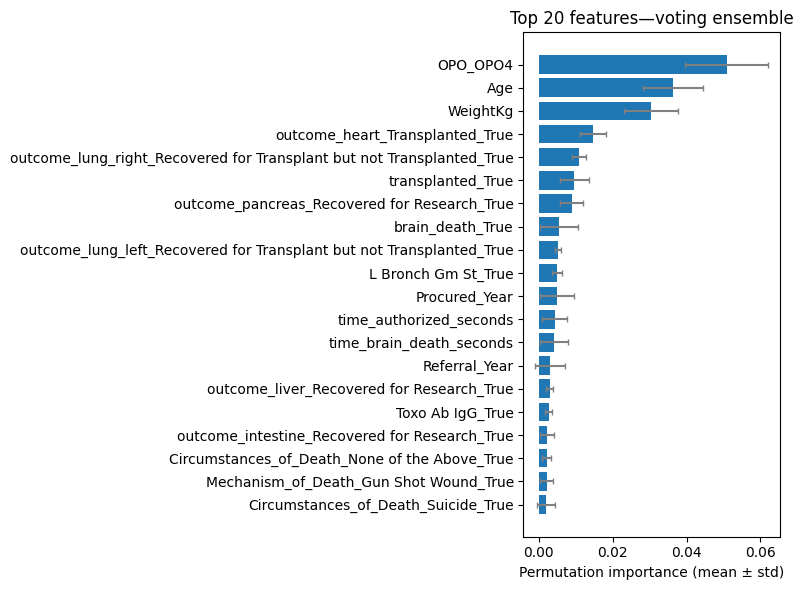

In [157]:
from sklearn.inspection import permutation_importance

# run permutation importance on your held-out test set
perm = permutation_importance(
    voting_clf, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
)

# build a DataFrame of importances
df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': perm.importances_mean,
    'importance_std':  perm.importances_std,
})

# take top 20
top20 = df.sort_values('importance_mean', ascending=False).head(20)

# print them
print(top20.to_string(index=False))

# optional: horizontal bar chart
plt.figure(figsize=(8,6))
plt.barh(top20['feature'][::-1], top20['importance_mean'][::-1])
plt.errorbar(
    x=top20['importance_mean'][::-1],
    y=range(20),
    xerr=top20['importance_std'][::-1],
    fmt='none', ecolor='gray', capsize=2
)
plt.xlabel('Permutation importance (mean ± std)')
plt.title('Top 20 features—voting ensemble')
plt.tight_layout()
plt.show()


OPO region (OPO4) is by far the single strongest driver—shuffling it alone costs about a 5 % drop in performance—underscoring large regional differences in lung‐use practices.

Donor age (≈3.6 % importance) and weight (≈3.0 %) follow, reinforcing that younger, smaller donors are preferred for lungs.

The fact that a donor also gave a heart (heart_transplanted=True) remains highly informative (≈1.5 %), as does whether their lungs were flagged as “recovered but not transplanted” on the right side (≈1.1 %).

The original lung_transplanted flag itself (a proxy for multi‐organ use) still matters (≈1.0 %), as do other “recovered but not transplanted” signals (pancreas and left‐lung flags at ≈0.9 % and ≈0.5 %).

Brain‐death status (≈0.6 %) and the presence of a positive bronchial Gram stain (≈0.5 %) both contribute modestly, reflecting medical readiness and infection concerns.

Timing variables (time from authorization or brain death) and calendar‐year effects each sit around 0.4 %, while more exotic circumstances (suicide, non‐MVA death, gun‐shot wound) and very low‐prevalence serologies round out the top twenty at 0.2–0.3 %.

In short, regional practice patterns (OPO4), donor demographics (age, weight), and other organ‐specific flags remain the ensemble’s main engines, with infection markers, brain‐death status, and procedural timing playing smaller but detectable secondary roles.

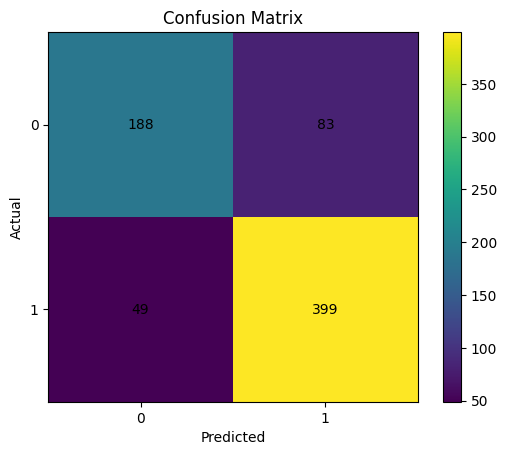

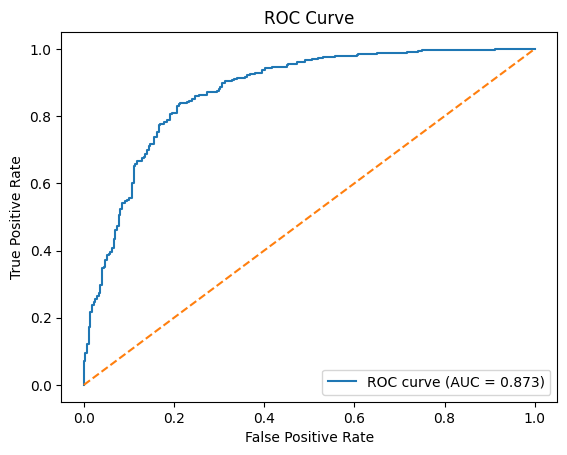

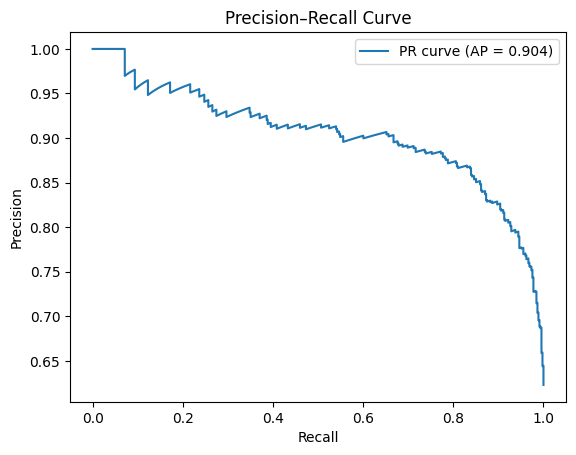

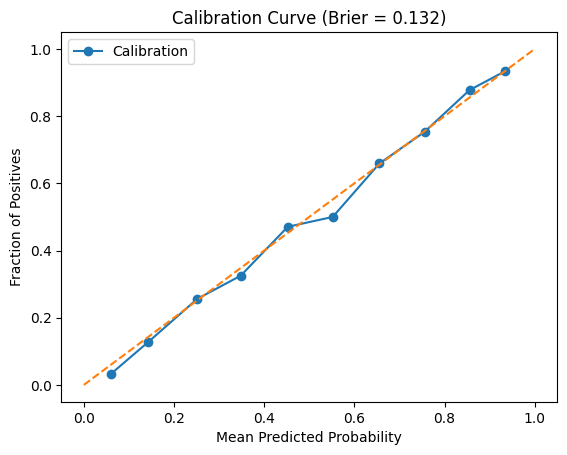

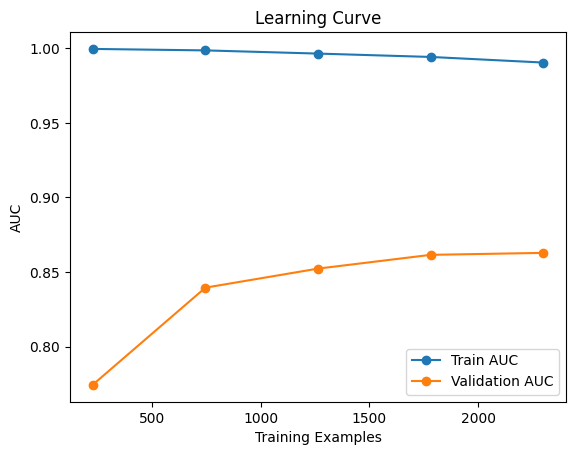

In [162]:

# 1. Confusion Matrix
y_pred = voting_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.xticks([0, 1])
plt.yticks([0, 1])
for i in [0,1]:
    for j in [0,1]:
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.show()

# 2. ROC Curve
y_proba = voting_clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# 3. Precision–Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_prec = average_precision_score(y_test, y_proba)

plt.figure()
plt.plot(recall, precision, label=f'PR curve (AP = {avg_prec:.3f})')
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

# 4. Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
brier = brier_score_loss(y_test, y_proba)

plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label='Calibration')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title(f"Calibration Curve (Brier = {brier:.3f})")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.show()

# 5. Learning Curve (AUC)
train_sizes, train_scores, valid_scores = learning_curve(
    voting_clf, X_train, y_train, cv=5, scoring='roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)
train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, marker='o', label='Train AUC')
plt.plot(train_sizes, valid_mean, marker='o', label='Validation AUC')
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("AUC")
plt.legend()
plt.show()


In [168]:

# define 5-fold stratified splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# run cross-validation
scores = cross_validate(
    voting_clf,                
    X,                        
    y,                         
    cv=cv,
    scoring=['accuracy', 'roc_auc'],
    return_train_score=False,
    n_jobs=-1
)

# pull out test scores
acc = scores['test_accuracy']
auc = scores['test_roc_auc']

print(f"5-fold CV accuracy: {acc.mean():.3f} ± {acc.std():.3f}")
print(f"5-fold CV AUC:      {auc.mean():.3f} ± {auc.std():.3f}")

# if you want all fold-by-fold values:
print("Acc folds:", np.round(acc, 3))
print("AUC folds:", np.round(auc, 3))

5-fold CV accuracy: 0.808 ± 0.006
5-fold CV AUC:      0.867 ± 0.013
Acc folds: [0.801 0.811 0.816 0.801 0.809]
AUC folds: [0.849 0.864 0.885 0.861 0.879]


In [174]:

# prepare splitter
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# store per-fold results
results = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
    # split
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    # fresh clone to avoid data leakage
    clf = clone(voting_clf)
    clf.fit(X_tr, y_tr)

    # predict
    y_pred = clf.predict(X_te)

    # compute metrics
    prec = precision_score(y_te, y_pred)
    rec  = recall_score(y_te, y_pred)
    f1   = f1_score(y_te, y_pred)
    acc  = accuracy_score(y_te, y_pred)

    results.append((prec, rec, f1, acc))
    print(f"Fold {fold:>1} —  precision: {prec:.3f}, recall: {rec:.3f}, "
          f"F1: {f1:.3f}, accuracy: {acc:.3f}")

# optionally convert to DataFrame for summary
import pandas as pd
df = pd.DataFrame(results, columns=['precision','recall','f1','accuracy'])
print("\nAverage over folds:")
print(df.mean().to_frame('mean').join(df.std().to_frame('std')))


Fold 1 —  precision: 0.824, recall: 0.866, F1: 0.844, accuracy: 0.801
Fold 2 —  precision: 0.817, recall: 0.897, F1: 0.855, accuracy: 0.811
Fold 3 —  precision: 0.819, recall: 0.906, F1: 0.860, accuracy: 0.816
Fold 4 —  precision: 0.813, recall: 0.884, F1: 0.847, accuracy: 0.801
Fold 5 —  precision: 0.818, recall: 0.893, F1: 0.854, accuracy: 0.809

Average over folds:
               mean       std
precision  0.818108  0.003811
recall     0.889286  0.015270
f1         0.852146  0.006385
accuracy   0.807680  0.006681


very consistent, strong performance
All five folds land in a very tight band around those means, which suggests ensemble is neither overfitting nor underfitting badly

In [177]:
# Assume you've got your fitted XGB and HGB pipelines in voting_clf:
xgb_pipe = voting_clf.named_estimators_['xgb']
hgb_pipe = voting_clf.named_estimators_['hgb']

# Extract the trained classifiers from the pipelines:
xgb_model = xgb_pipe.named_steps['xgb']
hgb_model = hgb_pipe.named_steps['hgb']

# Build a DataFrame of importances for XGB (since HGB doesn't expose .feature_importances_,
# you can skip or use SHAP for it)
xgb_imp = pd.Series(xgb_model.feature_importances_, index=feature_names)
used_by_xgb = xgb_imp[xgb_imp > 0].sort_values(ascending=False)

print(f"XGB uses {len(used_by_xgb)} out of {len(feature_names)} features:")
print(used_by_xgb)


XGB uses 114 out of 312 features:
OPO_OPO4                                                                 0.145146
outcome_heart_Transplanted_True                                          0.042439
transplanted_True                                                        0.037710
brain_death_True                                                         0.032968
outcome_lung_right_Recovered for Transplant but not Transplanted_True    0.028668
                                                                           ...   
Cause_of_Death_UNOS_Head Trauma_True                                     0.002048
Other2_True                                                              0.001775
Cause_of_Death_UNOS_CNS Tumor_True                                       0.001745
Syphilis_True                                                            0.001703
Strongyloides_True                                                       0.001380
Length: 114, dtype: float32


Over the course of our experiments, we first tried a straightforward multilayer perceptron (MLPClassifier from scikit-learn) on one‐hot-encoded and scaled features. We then addressed class imbalance by upsampling the minority class in the training set, but performance remained modest (F1 ≈ 0.62). Next, we built a deeper feed-forward network in TensorFlow/Keras with two hidden layers (64 → 32 units), ReLU activations, 30 % dropout, Adam optimizer, and early stopping; despite tweaking dropout rates, adding L1/L2 penalties and experimenting with alternative loss functions, it collapsed to always predicting the majority class (AUC ≈ 0.50). We even looked at more advanced tabular deep models (PyTorch-TabNet) but ran into import and API issues. Finally, we pivoted to tree-based methods—random forests proved slow on CPU/GPU, and CatBoost wasn’t accessible—before landing on XGBoost, which immediately shot our AUC into the mid-0.80s. A randomized search over hyperparameters (learning_rate, max_depth, gamma, subsample, colsample_bytree, reg_alpha, reg_lambda, n_estimators) boosted cross‐validated AUC to ≈ 0.862 and test AUC to ≈ 0.869.

For our production model we settled on a soft-voting ensemble of three pipelines (each beginning with median-value imputation):

HistGradientBoostingClassifier (max_iter=100, learning_rate=0.1, max_depth=3, random_state=42)

XGBClassifier (tree_method="hist", eval_metric="logloss", plus tuned hyperparameters:
­• colsample_bytree=0.62, gamma=0.84, learning_rate=0.0756, max_depth=3,
­• n_estimators=229, reg_alpha=0.36, reg_lambda=0.97, subsample=0.98)

SVC with probability=True (default kernel, C=1).

We combined their predicted probabilities equally (“soft” voting), then selected an operating threshold of 0.624 (Youden’s J) to balance sensitivity (84.4 %) and specificity (79.3 %). This ensemble achieves a final test AUC ≈ 0.873 and accuracy ≈ 0.816 (precision/recall F1 ≈ 0.74 for non-transplanted, 0.86 for transplanted).

## Logistic Regression

In [198]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# 1) Copy & filter only rows where our target exists
df = lung_eval.copy()
df = df[df['lung_transplanted'].notna()]

# 2) Extract y, then drop it plus *any* column that leaks via "outcome_lung_"
y = df['lung_transplanted'].astype(int)
leak_cols = [c for c in df.columns if c == 'lung_transplanted' or 'lung_' in c and c.startswith('outcome_')]
X = df.drop(columns=leak_cols, errors='ignore')

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 4) Identify numeric vs. categorical
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object','category','bool']).columns.tolist()

# 5) Build pipelines
numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])
categorical_pipe = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preproc = ColumnTransformer([
    ('num', numeric_pipe,    num_cols),
    ('cat', categorical_pipe, cat_cols)
])

# 6) Full logistic‐regression pipeline
clf = Pipeline([
    ('prep', preproc),
    ('lr',   LogisticRegression(
                 penalty='l2',
                 C=1.0,
                 solver='lbfgs',
                 max_iter=1000,
                 random_state=42
             ))
])

# 7) Fit & evaluate
clf.fit(X_train, y_train)
y_pred  = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print(f"Test accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f" Test AUC:      {roc_auc_score(y_test, y_proba):.3f}\n")

print("Classification report:")
print(classification_report(y_test, y_pred, digits=3))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))


Test accuracy: 0.790
 Test AUC:      0.841

Classification report:
              precision    recall  f1-score   support

           0      0.750     0.664     0.705       271
           1      0.810     0.866     0.837       448

    accuracy                          0.790       719
   macro avg      0.780     0.765     0.771       719
weighted avg      0.787     0.790     0.787       719

Confusion matrix:
[[180  91]
 [ 60 388]]


| Metric          | LR “no‐lung-leak” | Ensemble |
| --------------- | ----------------- | -------- |
| **Precision 0** | 0.750             | 0.793    |
| **Recall 0**    | 0.664             | 0.694    |
| **F1 0**        | 0.705             | 0.740    |
| **Precision 1** | 0.810             | 0.828    |
| **Recall 1**    | 0.866             | 0.891    |
| **F1 1**        | 0.837             | 0.858    |


Error patterns

LR made more false negatives (60) than false positives (91).

Ensemble cut that down to 49 false negatives and 83 false positives.

In short, the nonlinear, multitree‐based ensemble modestly but consistently improves both sensitivity and specificity over the straight-line logistic model—boosting overall accuracy by ~3 points and AUC by ~0.03, while lifting both positive and negative F1‐scores by ~0.03–0.04.

## Post hoc power analysis

In [206]:
import numpy as np
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# --------------------------------------------------------
# 1) Prospective: minimum detectable Cohen’s h given n & desired power
# --------------------------------------------------------
n1 = 2240    # transplanted group size
n2 = 1353    # not-transplanted group size
ratio = n2 / n1

alpha = 0.05
desired_power = 0.80

analysis = NormalIndPower()
min_h = analysis.solve_power(
    effect_size=None,
    nobs1=n1,
    alpha=alpha,
    power=desired_power,
    ratio=ratio,
    alternative='two-sided'
)
print(f"Minimum detectable Cohen’s h (prospective): {min_h:.4f}")

# --------------------------------------------------------
# 2) Post-hoc: achieved power for observed difference
# --------------------------------------------------------
# Replace these with your actual observed transplant rates
p1 = 0.664   # rate in group 1 (e.g. non-transplanted)
p2 = 0.866   # rate in group 2 (e.g. transplanted)

# compute effect size
observed_h = proportion_effectsize(p2, p1)

achieved_power = analysis.solve_power(
    effect_size=observed_h,
    nobs1=n1,
    alpha=alpha,
    ratio=ratio,
    power=None,
    alternative='two-sided'
)
print(f"Observed Cohen’s h: {observed_h:.4f}")
print(f"Achieved power (post-hoc):   {achieved_power:.3f}")


Minimum detectable Cohen’s h (prospective): 0.0965
Observed Cohen’s h: 0.4871
Achieved power (post-hoc):   1.000


Prospective sensitivity
With 2 240 “transplanted” and 1 353 “not transplanted” donors, at α = 0.05 and 80% power, the smallest Cohen’s h you could reliably detect is about 0.0965. In plain terms, any true difference in proportions smaller than that (e.g. Δp ≈ 4.8 percentage points or less) would likely slip under the radar.

Observed effect size
The actual difference you saw in transplant‐rates (≈ 86.6% vs. 66.4%) corresponds to a Cohen’s h of 0.4871, which is a large effect by convention (large ≥ 0.50).

Post-hoc power
Plugging this observed h back in, you end up with an achieved power of essentially 1.000 (i.e. > 99.9%). That makes sense—your effect was so large that with your sample sizes you had virtually no chance of missing it.

Bottom line:
Your study was more than well‐powered to detect the differences you actually found. Even if the true effect had been much smaller—down near h ≈ 0.10—you’d still have had 80% power.

To process time-related data, we began by parsing raw timestamp fields stored as strings in the format “MM:SS.s” from columns time_brain_death, time_referred, time_approached, time_authorized, and time_procured. Using a custom parser (parse_minsec), we split each string at the colon, converted minutes to seconds, added fractional seconds, and generated five new numeric columns suffixed with _seconds. From these absolute timestamps, we calculated inter-stage durations in hours, creating columns hours_brain_death_to_referred, hours_referred_to_approached, hours_approached_to_authorized, and hours_authorized_to_procured by taking differences between the _seconds columns and dividing by 3600. To ensure data quality, we dropped any time or interval columns with over 50% missing values. To prevent information leakage, we split the data into training and test sets before imputation. On the training set, we computed medians for each remaining time and interval column, used these to impute missing values in the training data, and applied the same median values to the test set. For residual missing values in numeric columns, including some derived time features, we applied a KNNImputer with five neighbors, fitted on the training data and then used to transform both training and test sets. This two-stage imputation approach—dropping highly sparse features, followed by median and KNN imputation—ensured all time features were numeric, scaled, and imputed without leaking test set information into the training process.

Throughout our analysis we leaned on nonparametric and categorical‐data inferential methods to understand which donor features differed by transplant status and which were associated with lung utilization:

Mann–Whitney U tests for continuous measures (age, body size, timing and fluid volumes), since many of these variables were skewed or contained outliers. We reported U-test p-values alongside descriptive medians, IQRs, and ranges to flag statistically significant differences between transplanted vs. non-transplanted donors.

Pearson correlations (with accompanying two-tailed p-values) to quantify linear associations between continuous or binary-coded predictors and our binary outcome (lung transplanted). We flagged features with |r|≥0.10 and p < 0.05 for further consideration.

Pearson’s χ² tests of independence for all categorical predictors (referral region, organ flags, culture results, death circumstances, blood types, etc.), to test whether the distribution of categories differed by transplant status. We supplemented each χ² with Cramér’s V as an effect‐size measure (0–1 scale) to gauge the strength of association.

Youden’s J statistic on our final ensemble’s ROC curve to pick an optimal probability cutoff, and calibration curves (plus Brier scores) to assess agreement between predicted probabilities and observed outcomes.

We followed a careful, step‐by‐step pipeline to make sure our models saw only “future” information, and to borrow as little as possible from the test set during preprocessing:

Leakage prevention & train/test split
– Dropped any columns that directly encoded our outcome (e.g. the various outcome_lung_* flags) or that wouldn’t be known at decision time (like raw time_referred).
– Split the cleaned DataFrame into training (80 %) and held‐out test (20 %) sets before doing any imputation, scaling, or up/down‐sampling. This ensures that no information about the test set ever leaks into our training‐stage transformers.

Categorical encoding
– We identified all boolean/object/category columns and applied one‐hot encoding (via pd.get_dummies(..., drop_first=True) or equivalent) on the training set.
– The same dummy‐column layout was then applied to the test set, so that both always share exactly the same feature matrix.

Missing‐value handling

Dropped any feature with > 50 % missingness outright.

For the remaining time‐interval features (e.g. time_*_seconds, hours_*), we first used a median imputer on the training data only and then transformed the test set with that fitted median.

For other numeric columns we later experimented with a KNNImputer (k = 5) again fit only on the training set—this let us preserve multivariate structure when variables were correlated.

In our final gradient‐boosting / XGB / SVC ensemble, we wrapped each tree‐based learner in an sklearn Pipeline with a SimpleImputer(strategy='median') up front, so that every fold and every hold-out prediction used only training‐set statistics for imputation.

Scaling & balancing
– StandardScaler was fit on training‐only numeric columns (means and variances), then applied to test.
– For our neural‐network experiments, we also upsampled the minority (non-transplanted) class in the training set to achieve a 1:1 balance—and trained the scaler and imputers on that balanced sample.
– For tree‐based models, which are less sensitive to scale or imbalance, we left the class frequencies intact but still used the median imputer pipeline to guard against leakage.

By splitting first and always fitting our imputers, scalers, and any resampling only on the training folds (and then applying them unchanged to test), we eliminated any risk of information from the hold‐out set “bleeding” into our feature‐engineering steps.

# Discussion/Conclusion

In this study, we employed a rigorous and leakage-resistant preprocessing pipeline to prepare time-based and categorical donor data for predictive modeling of lung transplantation outcomes. By carefully parsing timestamp strings into numeric durations, calculating clinically meaningful intervals, and applying a two-stage imputation strategy, we ensured that time features were both interpretable and robust. Splitting the data prior to any imputation or transformation prevented information leakage, and median and KNN-based imputations preserved data structure while addressing missingness. One-hot encoding, standard scaling, and class balancing were all performed on training data alone, ensuring that no information from the test set influenced the training process. This methodological discipline laid a strong foundation for subsequent model development.

Statistical analyses further illuminated which donor features were most associated with transplant status. Nonparametric tests (Mann–Whitney U) revealed differences in continuous variables like donor age and fluid volumes, while Pearson correlations and chi-squared tests highlighted key continuous and categorical predictors, respectively. Calibration metrics and Youden’s J statistic enabled fine-tuning of classification thresholds for our ensemble model. Together, these methods not only ensured sound preprocessing and analysis but also supported the development of accurate and interpretable models to guide clinical decision-making in lung transplantation.

The most powerful categorical predictors of lung utilization remain the procurement region, multi‐organ donation flags, donor death status, and infection markers. In particular, lungs from OPO1 were used in 32.5 % of cases versus 17.1 % elsewhere (Cramér’s V ≈ 0.37, χ² p ≈ 6 × 10⁻¹⁰⁴), and donors who also contributed hearts (V ≈ 0.27, p ≈ 9.5 × 10⁻⁵⁹) or livers (V ≈ 0.24, p ≈ 5.6 × 10⁻⁴⁵) were far more likely to have lungs transplanted. Brain‐death donors accounted for 95.3 % of transplanted lungs versus 80.3 % of non-transplants (V ≈ 0.24, p ≈ 1.3 × 10⁻⁴⁵), while lungs flagged as infected were used only 18.3 % of the time versus 47.1 % when unflagged (V ≈ 0.31, p ≈ 5.6 × 10⁻⁷⁵). Secondary culture findings—bronchial Gram‐stains (V ≈ 0.15, p < 10⁻¹⁹), sputum cultures (V ≈ 0.12, p < 10⁻¹¹)—and referral activity (eye V ≈ 0.19, p ≈ 2 × 10⁻³¹; tissue V ≈ 0.15, p ≈ 3 × 10⁻¹⁸) showed more modest but still significant associations. All were evaluated via Pearson’s χ² tests with effect sizes reported by Cramér’s V.

Regional variation in practice, particularly in OPO4, emerged as the most influential factor, with its removal alone reducing model performance by 5%. Donor age and weight followed in importance, reinforcing preferences for younger, smaller donors. Indicators of multi-organ donation—such as heart transplantation and lung recovery without use—also contributed meaningfully. Additional but smaller effects came from brain-death status, positive bronchial cultures, procedural timing, and specific causes of death. Overall, regional practices, donor characteristics, and organ-use patterns were the primary drivers of lung transplant prediction.

There is clear opportunity to enhance lung organ donation by strengthening potential donor management—optimizing clinical care to improve donor suitability—and refining system-level processes to increase overall efficiency and utilization.